In [31]:
# [2.2] Setup: import libraries used across dataset loading, DL model, training/eval, and benchmarks
import os
import random
import math
import warnings
from itertools import accumulate
from typing import Optional, List, Tuple
import tqdm

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import PearsonCorrCoef

from einops import rearrange
from einops.layers.torch import Rearrange

from transformers import BertPreTrainedModel
from transformers.modeling_utils import ModuleUtilsMixin
from transformers.models.bert.modeling_bert import (
    BertConfig, 
    BertEmbeddings, 
    BertEncoder, 
    BertLayer, 
    BertAttention
)

In [33]:
# [2.1/2.3] Data pipeline: load EN-selected SNPs, compute LD-gap tokens, build sequences, standardize labels, and create KFold split-based PyTorch Dataset
class DNADataset(Dataset):
    # Updated __init__ to accept ld_threshold
    def __init__(self, data_path, label_path, geno_path, trait, seed, sel_num, ld_threshold=0.8, is_training=True):
        cs = pd.read_csv(f"{data_path}{seed}.csv").sort_values(by='cs', ascending=False)
        Top = sorted(cs.index[:sel_num])  
        Rawgeno = pd.read_csv(geno_path)

        # DROP the first row (SNP index row)
        Rawgeno = Rawgeno.iloc[1:].reset_index(drop=True)

        Top = [i for i in Top if i in Rawgeno.index]

        geno = Rawgeno.loc[Top].copy()

        # explicitly separate columns
        geno_cols = [c for c in geno.columns if c not in ['chrom']]

        LD = self.calculate_LD(geno)
        
        # Pass the variable threshold here
        geno['gap'] = self.assign_gap_labels(LD, ld_threshold)
        
        geno = geno.drop(columns=geno.columns[[-3, -2]])  
        lines = self.generate_geno_sequences(geno)
        annos = pd.read_csv(label_path, index_col=0).iloc[:, [trait]]
        annos = annos.fillna(annos.mean()) 
        annos = StandardScaler().fit_transform(annos).astype(np.float32)

        kfold = KFold(n_splits=5, shuffle=True, random_state=27)
        for i, (train_idx, val_idx) in enumerate(kfold.split(lines, annos)):
            if i == seed:
                train_lines, val_lines = lines[train_idx], lines[val_idx]
                train_annos, val_annos = annos[train_idx], annos[val_idx]                
                break

        train_seqs, train_type_ids = self.process_sequences(train_lines)
        val_seqs, val_type_ids = self.process_sequences(val_lines)

        if is_training:
            self.seqs, self.type_ids, self.annos = train_seqs, train_type_ids, train_annos
        else:
            self.seqs, self.type_ids, self.annos = val_seqs, val_type_ids, val_annos

    def calculate_LD(self, geno):
        geno_values = np.select(
            [geno.iloc[:, :-2].values == 'H', geno.iloc[:, :-2].values == 'M', geno.iloc[:, :-2].values == 'L'],
            [0, 1, 2],
            default=-1
        ) 

        a, b = geno_values[:-1], geno_values[1:]  
        var_a, var_b = np.var(a, axis=1), np.var(b, axis=1)
        mean_a, mean_b = np.mean(a, axis=1), np.mean(b, axis=1)
        d = np.mean((a - mean_a[:, None]) * (b - mean_b[:, None]), axis=1)
        
        LD = np.where((var_a == 0) | (var_b == 0), 0, (d ** 2) / (var_a * var_b))
        LD = np.append(LD, -1)  

        chrom = sorted(set(geno['chrom']))
        index = list(accumulate([len(geno.groupby('chrom').get_group(i)) for i in chrom])) 
        for idx in index:
            LD[idx - 1] = -1        
        return LD

    # Updated to accept threshold parameter
    def assign_gap_labels(self, LD, threshold):
        return np.where(LD == -1, 'N', np.where(LD >= threshold, 'J', 'Y'))

    def generate_geno_sequences(self, geno):
        lines = []
        for i in range(geno.shape[1] - 1):
            geno.iloc[:, i] = geno.iloc[:, i] + geno['gap']
            lines.append(''.join(geno.iloc[:, i]))
        return np.stack(lines, axis=0)

    def process_sequences(self, lines):
        vocabs = {f"{a}{b}": i + 1 for i, (a, b) in enumerate([("H", "J"), ("H", "Y"), ("H", "N"), ("L", "J"), ("L", "Y"), ("L", "N"), ("M", "J"), ("M", "Y"), ("M", "N")])}
        type_vocabs = {"J": 1, "Y": 2, "N": 3}

        seqs, type_ids = [], []
        for raw_seq in lines:
            seq, type_id = [], []
            for i in range(0, len(raw_seq), 2):
                seq.append(vocabs[raw_seq[i:i + 2]])
                type_id.append(type_vocabs[raw_seq[i + 1]])
            seqs.append(seq)
            type_ids.append(type_id)

        return np.asarray(seqs), np.asarray(type_ids)

    def __len__(self):
        return len(self.annos)

    def __getitem__(self, index):
        seq = torch.tensor(self.seqs[index], dtype=torch.float32)
        type_ids = torch.tensor(self.type_ids[index], dtype=torch.float32)
        annos = torch.tensor(self.annos[index], dtype=torch.float32)
        return seq, type_ids, annos

In [34]:
# [2.2] Model definitions: EBMGP architecture + pooling modules (MAP/AVG/MAX/LIP) to support pooling ablation experiments
class soft_pool1d(nn.Module):
    def __init__(self,  kernel_size=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride= kernel_size
    def forward(self, x):
        e_x = torch.sum(torch.exp(x),dim=1,keepdim=True)
        return F.avg_pool1d(x.mul(e_x), self.kernel_size, stride=self.stride).mul_(self.kernel_size).div_(F.avg_pool1d(e_x, self.kernel_size, stride=self.stride).mul_(self.kernel_size))

def lip1d(x, logit, kernel=3, stride=2, padding=1):
    weight = logit.exp()
    return F.avg_pool1d(x*weight, kernel, stride, padding)/F.avg_pool1d(weight, kernel, stride, padding)
    
class LIP(nn.Module):
    # Updated to accept pool_size to match AttentionPool's stride/reduction behavior
    def __init__(self, channels, pool_size=2):
        super(LIP, self).__init__()
        self.pool_size = pool_size
        self.logit = nn.Sequential(
                nn.Conv1d(channels, channels, 3, padding=1, bias=False),
                nn.BatchNorm1d(channels, affine=True),
                nn.ReLU(),
        )
    def init_layer(self):
        self.logit[0].weight.data.fill_(0.0)

    def forward(self, x):
        # Pass pool_size as kernel and stride to mimic other pooling layers
        # padding is set to pool_size // 2 to maintain consistency
        frac = lip1d(x, self.logit(x), kernel=self.pool_size, stride=self.pool_size, padding=self.pool_size//2)
        return frac

class AttentionPool(nn.Module):
    def __init__(self, dim, pool_size=2,dropout_prob=0.1):
        super().__init__()
        self.pool_size = pool_size
        self.attn_dropout = nn.Dropout(dropout_prob)
        self.to_attn_logits1 = nn.Conv2d(dim, dim, 1, bias=False)
        self.to_attn_logits2 = nn.ModuleList([nn.Conv1d(dim, dim, 1, bias=False) for _ in range(pool_size)])
        self.BN = nn.BatchNorm1d(dim)
    def forward(self, x):
        b, s, n = x.shape  
        remainder = n % self.pool_size
        needs_padding = remainder > 0      
        if needs_padding:
            x = F.pad(x, (0, (self.pool_size-remainder)), value=0) 
        x = x.unfold(-1,self.pool_size,self.pool_size) 
        outx = []
        i = 0
        for conv in self.to_attn_logits2:                
            nx = x[:,:,:,i]
            nx = self.BN(nx)
            logit = conv(nx)           
            outx.append(logit)
            i+=1 
        outx = torch.stack(outx, dim=-1)       
        logits =  self.to_attn_logits1(outx)
        logits = self.attn_dropout(logits)             
        attn = logits.softmax(dim=-1)             
        outs = (outx * attn).sum(dim=-1)
        return outs
  
class GELU(nn.Module):
    def forward(self, x):
        return torch.sigmoid(1.702 * x) * x
        
def ConvBlock(dim, dimout, kernel_size = 1,stride=2):
    return nn.Sequential(
        nn.BatchNorm1d(dim),
        GELU(),
        nn.Conv1d(dim,  dimout, kernel_size,stride=stride, padding = kernel_size // 2)
    )

class EBMGP(nn.Module):
    def __init__(
        self,
        vocab_size: int = 10,
        type_vocab_size: int = 4,
        hidden_size: int = 64,
        num_layers: int = 1,
        num_attention_heads: int = 8,
        intermediate_size: int = 256,
        hidden_act: str = "gelu",
        dropout_rate: float = 0.3,
        pooling_type: str = "MAP" # New Argument
    ):
        super().__init__()

        self.config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_hidden_layers=num_layers,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            hidden_act=hidden_act,
            type_vocab_size=type_vocab_size,
            max_position_embeddings=5000, 
            dropout_rate = dropout_rate,
        )

        self.embeddings = BertEmbeddings(self.config)

        # Factory method to select pooling layer
        def get_pool(dim, size):
            if pooling_type == "MAP":
                return AttentionPool(dim, pool_size=size)
            elif pooling_type == "AVG":
                return nn.AvgPool1d(kernel_size=size, stride=size)
            elif pooling_type == "MAX":
                return nn.MaxPool1d(kernel_size=size, stride=size)
            elif pooling_type == "LIP":
                return LIP(dim, pool_size=size)
            else:
                raise ValueError(f"Unknown pooling type: {pooling_type}")

        self.convs = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            ConvBlock(hidden_size, 64,30,stride=2),
            get_pool(64, 1), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 3,stride=2),            
            get_pool(64, 2), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 30,stride=2),           
            get_pool(64, 3), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 3,stride=2),            
            get_pool(64, 2), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 30,stride=2),           
            get_pool(64, 3), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 
        )
          
        self.predictor = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),       
            Rearrange('b c l -> b (c l)'), 
            nn.Linear(64, 1),              
        )

    def forward(
        self,
        input_ids: torch.Tensor,
        token_type_ids: torch.Tensor,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
        return_dict: bool = False,
    ):
        embedding_output = self.embeddings(
            input_ids=input_ids.long(),
            position_ids=position_ids,
            token_type_ids=token_type_ids.long(),
        )
        x = embedding_output.permute(0, 2, 1) 
        x = self.convs(x)
        logits = self.predictor(x) 
        return logits

In [36]:
# [2.3] Training & evaluation: reproducibility seed, epoch loops, metrics (Pearson/RMSE/R2), and a train_and_evaluate wrapper used by experiments

import os
import math
import random
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchmetrics import PearsonCorrCoef
from sklearn.metrics import mean_squared_error, r2_score

def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    train_loss = []
    for batch_idx, (seqs, type_ids, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        seqs, type_ids, labels = seqs.to(device), type_ids.to(device), labels.to(device)
        predict = model(seqs, type_ids)
        loss = loss_fn(predict, labels)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
    return np.mean(train_loss)


def evaluate_epoch(model, test_loader, loss_fn, pearson, device):
    model.eval()
    valid_loss = []
    vp, vt = [], []
    with torch.no_grad():
        for seqs, type_ids, labels in test_loader:
            seqs, type_ids, labels = seqs.to(device), type_ids.to(device), labels.to(device)
            pred = model(seqs, type_ids)
            val_loss = loss_fn(pred, labels)
            valid_loss.append(val_loss.item())
            vp.extend(pred.squeeze().cpu().numpy())
            vt.extend(labels.squeeze().cpu().numpy())
    return np.mean(valid_loss), vp, vt

from sklearn.metrics import r2_score

# Added pooling_type argument
def train_and_evaluate(trait, data_path, label_path, geno_path, device,
                       learning_rate, epochs, seed, sel_num,
                       ld_threshold=0.8, pooling_type="MAP"):

    # Make runs reproducible BUT different per fold
    setup_seed(3407 + seed)   # (you can also do setup_seed(seed) if you prefer)

    loss_fn = nn.L1Loss()
    bs = 32

    traindataset = DNADataset(
        data_path, label_path, geno_path, trait, seed, sel_num,
        ld_threshold=ld_threshold, is_training=True
    )
    testdataset = DNADataset(
        data_path, label_path, geno_path, trait, seed, sel_num,
        ld_threshold=ld_threshold, is_training=False
    )

    train_loader = DataLoader(traindataset, batch_size=bs, shuffle=True)
    test_loader  = DataLoader(testdataset,  batch_size=bs, shuffle=False)

    print(f"Seed {seed} | Pool {pooling_type} | Train Samples: {len(traindataset)} | Test Samples: {len(testdataset)}")

    model = EBMGP(pooling_type=pooling_type).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    steps = math.ceil(len(traindataset) / bs) * epochs - 1
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)

    pearson = PearsonCorrCoef().to(device)

    # ----- NEW: track best epoch by Pearson correlation -----
    best_corr = -1e9
    best_rmse = None
    best_pred = None
    best_obser = None
    best_epoch = 0

    patience = 15
    min_delta = 1e-4
    no_improve = 0

    # If runtime is slow, change this to 5 or 10
    eval_every = 1

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)

        do_eval = (epoch % eval_every == 0) or (epoch == epochs)
        if do_eval:
            valid_loss, vp, vt = evaluate_epoch(model, test_loader, loss_fn, pearson, device)

            # vp/vt are python lists in your evaluate_epoch() (cell [2.3])
            val_rmse = np.sqrt(mean_squared_error(vp, vt))

            v_corr = pearson(
                torch.tensor(vp, device=device),
                torch.tensor(vt, device=device)
            ).item()

            # Keep the best checkpoint by Pearson correlation
            if v_corr > best_corr + min_delta:
                best_corr = v_corr
                best_rmse = val_rmse
                best_pred = list(vp)
                best_obser = list(vt)
                best_epoch = epoch
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch} (best epoch {best_epoch}, best corr {best_corr:.4f})")
                break

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"   Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f} | Val Corr: {v_corr:.4f} | Val RMSE: {val_rmse:.4f}")

    print(f"BEST epoch = {best_epoch} | BEST Corr = {best_corr:.4f} | RMSE@BEST = {best_rmse:.4f}")
    print("-" * 40)

    # Return best-by-corr metrics (this will directly affect your benchmark table)
    return best_corr, best_rmse, best_pred, best_obser


In [37]:
# [3] Ablation study pipeline: (1) LD threshold sweep and (2) pooling strategy sweep; trains EBMGP across seeds/species/traits and saves mean metrics to JSON

import torch
import numpy as np
import os
import json

# --- Configuration ---
learning_rate = 0.0005
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optimal Feature Counts per Species (Used for both ablations)
species_optimal_counts = {
    "rice": 5000,
    "sorghum": 5000,
    # "soybean": 3000,
    "bulls": 5000
}

species_config = {
    "rice": {
        "label_path": "./data/rice_pheno.csv",
        "geno_path": "./data/ricerawgeno.csv",
        "traits": ['SW', 'FLW', 'AC', 'PH', 'SNPP']
    },
    "sorghum": {
        "label_path": "./data/sorghum_pheno.csv",
        "geno_path": "./data/sorghumrawgeno.csv",
        "traits": ['HT', 'MO', 'YLD']
    },
    # "soybean": {
    #     "label_path": "./data/soybean_pheno.csv",
    #     "geno_path": "./data/soybeanrawgeno.csv",
    #     "traits": ['protein', 'Steartic', 'R8', 'SdWgt', 'Yield']
    # },
    "bulls": {
        "label_path": "./data/bulls_pheno.csv",
        "geno_path": "./data/bullsrawgeno.csv",
        "traits": ['MS', 'NMSP', 'VE']
    }
}

# --- Experiment 1: LD Threshold Ablation ---
def run_ld_ablation():
    print("\n" + "#"*60)
    print("RUNNING EXPERIMENT: LD THRESHOLD ABLATION")
    print("#"*60)
    
    ld_thresholds = [0.2, 0.4, 0.6, 0.8]
    
    for species, optimal_count in species_optimal_counts.items():
        config = species_config[species]
        sel_num = optimal_count
        T_folder = f"T{optimal_count}"
        
        for ld_thresh in ld_thresholds:
            print(f"\n   >>> Processing LD Threshold: {ld_thresh} | Species: {species} | Feature Count: {T_folder}")
            
            results_data = {
                "species": species,
                "feature_count": optimal_count,
                "ld_threshold": ld_thresh,
                "pooling_type": "MAP", # Default for LD ablation
                "mean_corrs": {},
                "mean_RMSE": {}
            }

            for trait_idx, trait_name in enumerate(config["traits"]):
                data_path = f"./EN/{species}/{T_folder}{trait_name}"
                
                if not os.path.exists(f"{data_path}0.csv"):
                    continue

                corrs, RMSE = [], []
                print(f"      Processing Trait: {trait_name}")
                
                for seed in range(5):
                    try:
                        # Uses default pooling_type="MAP"
                        fold_corrs, fold_RMSE, _, _ = train_and_evaluate(
                            trait_idx, data_path, config["label_path"], config["geno_path"], 
                            device, learning_rate, epochs, seed, sel_num,
                            ld_threshold=ld_thresh, pooling_type="MAP"
                        )
                        corrs.append(fold_corrs)
                        RMSE.append(fold_RMSE)
                    except Exception as e:
                        print(f"         [Error] Seed {seed}: {e}")

                if corrs:
                    results_data["mean_corrs"][trait_name] = float(np.mean(corrs))
                    results_data["mean_RMSE"][trait_name] = float(np.mean(RMSE))

            # Save JSON
            json_filename = f"{species}_{T_folder}_LD{ld_thresh}.json"
            with open(json_filename, "w") as f:
                json.dump(results_data, f, indent=4)
            print(f"   [Saved] {json_filename}")


# --- Experiment 2: Pooling Strategy Ablation ---
def run_pooling_ablation():
    print("\n" + "#"*60)
    print("RUNNING EXPERIMENT: POOLING STRATEGY ABLATION")
    print("#"*60)
    
    pooling_types = ["MAP", "AVG", "MAX", "LIP"]
    
    for species, optimal_count in species_optimal_counts.items():
        config = species_config[species]
        sel_num = optimal_count
        T_folder = f"T{optimal_count}"
        
        for p_type in pooling_types:
            print(f"\n   >>> Processing Pooling Type: {p_type} | Species: {species} | Feature Count: {T_folder}")
            
            results_data = {
                "species": species,
                "feature_count": optimal_count,
                "ld_threshold": 0.8, # Default for Pooling ablation
                "pooling_type": p_type,
                "mean_corrs": {},
                "mean_RMSE": {}
            }

            for trait_idx, trait_name in enumerate(config["traits"]):
                data_path = f"./EN/{species}/{T_folder}{trait_name}"
                
                if not os.path.exists(f"{data_path}0.csv"):
                    continue

                corrs, RMSE = [], []
                print(f"      Processing Trait: {trait_name}")
                
                for seed in range(5):
                    try:
                        # Uses default ld_threshold=0.8
                        fold_corrs, fold_RMSE, _, _ = train_and_evaluate(
                            trait_idx, data_path, config["label_path"], config["geno_path"], 
                            device, learning_rate, epochs, seed, sel_num,
                            ld_threshold=0.8, pooling_type=p_type
                        )
                        corrs.append(fold_corrs)
                        RMSE.append(fold_RMSE)
                    except Exception as e:
                        print(f"         [Error] Seed {seed}: {e}")

                if corrs:
                    results_data["mean_corrs"][trait_name] = float(np.mean(corrs))
                    results_data["mean_RMSE"][trait_name] = float(np.mean(RMSE))

            # Save JSON
            json_filename = f"{species}_{T_folder}_{p_type}.json"
            with open(json_filename, "w") as f:
                json.dump(results_data, f, indent=4)
            print(f"   [Saved] {json_filename}")

def main():
    # You can comment out one of these lines if you only want to run one experiment
    run_ld_ablation()
    run_pooling_ablation()

if __name__ == "__main__":
    main()


############################################################
RUNNING EXPERIMENT: LD THRESHOLD ABLATION
############################################################

   >>> Processing LD Threshold: 0.2 | Species: rice | Feature Count: T5000
      Processing Trait: SW
Seed 0 | Pool MAP | Train Samples: 330 | Test Samples: 83
   Epoch 1/100 | Train Loss: 0.8110 | Val Loss: 0.6833 | Val Corr: 0.5132 | Val RMSE: 0.8941
   Epoch 10/100 | Train Loss: 0.6960 | Val Loss: 0.5553 | Val Corr: 0.5883 | Val RMSE: 0.7300
   Epoch 20/100 | Train Loss: 0.6229 | Val Loss: 0.5179 | Val Corr: 0.6327 | Val RMSE: 0.6966
   Epoch 30/100 | Train Loss: 0.5650 | Val Loss: 0.5836 | Val Corr: 0.6070 | Val RMSE: 0.7694
Early stopping at epoch 39 (best epoch 24, best corr 0.6645)
BEST epoch = 24 | BEST Corr = 0.6645 | RMSE@BEST = 0.6970
----------------------------------------
Seed 1 | Pool MAP | Train Samples: 330 | Test Samples: 83
   Epoch 1/100 | Train Loss: 0.7621 | Val Loss: 0.7083 | Val Corr: 0.3723 | Val R

/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7536 | Val Loss: 0.7654 | Val Corr: 0.4017 | Val RMSE: 0.9386
   Epoch 10/100 | Train Loss: 0.6167 | Val Loss: 0.6478 | Val Corr: 0.4994 | Val RMSE: 0.8646
   Epoch 20/100 | Train Loss: 0.4668 | Val Loss: 0.6170 | Val Corr: 0.5157 | Val RMSE: 0.8095
   Epoch 30/100 | Train Loss: 0.4076 | Val Loss: 0.6601 | Val Corr: 0.4609 | Val RMSE: 0.8651
Early stopping at epoch 37 (best epoch 22, best corr 0.5178)
BEST epoch = 22 | BEST Corr = 0.5178 | RMSE@BEST = 0.8097
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7872 | Val Loss: 0.7837 | Val Corr: 0.3695 | Val RMSE: 1.0806
   Epoch 10/100 | Train Loss: 0.5750 | Val Loss: 0.7183 | Val Corr: 0.5156 | Val RMSE: 1.0251
   Epoch 20/100 | Train Loss: 0.4355 | Val Loss: 0.7246 | Val Corr: 0.4841 | Val RMSE: 1.0382
Early stopping at epoch 22 (best epoch 7, best corr 0.5240)
BEST epoch = 7 | BEST Corr = 0.5240 | RMSE@BEST = 1.0675
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7653 | Val Loss: 0.9049 | Val Corr: 0.3084 | Val RMSE: 1.0754
   Epoch 10/100 | Train Loss: 0.5852 | Val Loss: 0.6746 | Val Corr: 0.5594 | Val RMSE: 0.8576
   Epoch 20/100 | Train Loss: 0.4770 | Val Loss: 0.6206 | Val Corr: 0.5859 | Val RMSE: 0.8297
   Epoch 30/100 | Train Loss: 0.4163 | Val Loss: 0.6885 | Val Corr: 0.5902 | Val RMSE: 0.8517
   Epoch 40/100 | Train Loss: 0.3397 | Val Loss: 0.6314 | Val Corr: 0.5849 | Val RMSE: 0.8151
Early stopping at epoch 44 (best epoch 29, best corr 0.6083)
BEST epoch = 29 | BEST Corr = 0.6083 | RMSE@BEST = 0.7956
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7630 | Val Loss: 0.8188 | Val Corr: 0.3559 | Val RMSE: 1.0060
   Epoch 10/100 | Train Loss: 0.5609 | Val Loss: 0.7328 | Val Corr: 0.4800 | Val RMSE: 0.8982
   Epoch 20/100 | Train Loss: 0.4755 | Val Loss: 0.7614 | Val Corr: 0.4697 | Val RMSE: 0.9734
Early stopping at epoch 27 (best epoch 12, best corr 0.5290)
BEST epoch = 12 | BEST Corr = 0.5290 | RMSE@BEST = 0.8696
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7825 | Val Loss: 0.7516 | Val Corr: 0.4656 | Val RMSE: 0.9682
   Epoch 10/100 | Train Loss: 0.5730 | Val Loss: 0.6917 | Val Corr: 0.5480 | Val RMSE: 0.8649
   Epoch 20/100 | Train Loss: 0.4518 | Val Loss: 0.6151 | Val Corr: 0.5905 | Val RMSE: 0.7866
   Epoch 30/100 | Train Loss: 0.3932 | Val Loss: 0.6693 | Val Corr: 0.5402 | Val RMSE: 0.8251
Early stopping at epoch 35 (best epoch 20, best corr 0.5905)
BEST epoch = 20 | BEST Corr = 0.5905 | RMSE@BEST = 0.7866
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7714 | Val Loss: 0.8600 | Val Corr: 0.1313 | Val RMSE: 1.0677
   Epoch 10/100 | Train Loss: 0.6322 | Val Loss: 0.8356 | Val Corr: 0.2253 | Val RMSE: 1.0477
   Epoch 20/100 | Train Loss: 0.5227 | Val Loss: 0.9146 | Val Corr: 0.2741 | Val RMSE: 1.1323
   Epoch 30/100 | Train Loss: 0.4318 | Val Loss: 0.8882 | Val Corr: 0.2024 | Val RMSE: 1.1271
Early stopping at epoch 31 (best epoch 16, best corr 0.2950)
BEST epoch = 16 | BEST Corr = 0.2950 | RMSE@BEST = 1.0162
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7980 | Val Loss: 0.6748 | Val Corr: 0.4583 | Val RMSE: 0.8433
   Epoch 10/100 | Train Loss: 0.5997 | Val Loss: 0.7620 | Val Corr: 0.4150 | Val RMSE: 0.8823
Early stopping at epoch 16 (best epoch 1, best corr 0.4583)
BEST epoch = 1 | BEST Corr = 0.4583 | RMSE@BEST = 0.8433
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7837 | Val Loss: 0.7285 | Val Corr: 0.3696 | Val RMSE: 0.9106
   Epoch 10/100 | Train Loss: 0.6441 | Val Loss: 0.6499 | Val Corr: 0.4597 | Val RMSE: 0.8185
Early stopping at epoch 20 (best epoch 5, best corr 0.4787)
BEST epoch = 5 | BEST Corr = 0.4787 | RMSE@BEST = 0.7991
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7742 | Val Loss: 0.7530 | Val Corr: 0.1085 | Val RMSE: 0.9497
   Epoch 10/100 | Train Loss: 0.6031 | Val Loss: 0.7230 | Val Corr: 0.2678 | Val RMSE: 0.9751
   Epoch 20/100 | Train Loss: 0.4881 | Val Loss: 0.7499 | Val Corr: 0.2771 | Val RMSE: 0.9752
   Epoch 30/100 | Train Loss: 0.4721 | Val Loss: 0.7130 | Val Corr: 0.3066 | Val RMSE: 0.9319
   Epoch 40/100 | Train Loss: 0.3781 | Val Loss: 0.7859 | Val Corr: 0.2904 | Val RMSE: 0.9791
Early stopping at epoch 45 (best epoch 30, best corr 0.3066)
BEST epoch = 30 | BEST Corr = 0.3066 | RMSE@BEST = 0.9319
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7586 | Val Loss: 0.9172 | Val Corr: 0.3506 | Val RMSE: 1.1894
   Epoch 10/100 | Train Loss: 0.5696 | Val Loss: 0.7766 | Val Corr: 0.4491 | Val RMSE: 1.0630
   Epoch 20/100 | Train Loss: 0.4471 | Val Loss: 0.8168 | Val Corr: 0.4198 | Val RMSE: 1.0859
   Epoch 30/100 | Train Loss: 0.3916 | Val Loss: 0.7416 | Val Corr: 0.5351 | Val RMSE: 1.0169
   Epoch 40/100 | Train Loss: 0.3747 | Val Loss: 0.7869 | Val Corr: 0.4689 | Val RMSE: 1.0644
Early stopping at epoch 49 (best epoch 34, best corr 0.5545)
BEST epoch = 34 | BEST Corr = 0.5545 | RMSE@BEST = 1.0009
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7706 | Val Loss: 0.8553 | Val Corr: 0.4346 | Val RMSE: 1.0353
   Epoch 10/100 | Train Loss: 0.5532 | Val Loss: 0.7013 | Val Corr: 0.5771 | Val RMSE: 0.9188
   Epoch 20/100 | Train Loss: 0.4424 | Val Loss: 0.8020 | Val Corr: 0.5991 | Val RMSE: 1.0439
   Epoch 30/100 | Train Loss: 0.3724 | Val Loss: 0.6533 | Val Corr: 0.5899 | Val RMSE: 0.8487
   Epoch 40/100 | Train Loss: 0.3152 | Val Loss: 0.6640 | Val Corr: 0.6086 | Val RMSE: 0.8729
Early stopping at epoch 50 (best epoch 35, best corr 0.6149)
BEST epoch = 35 | BEST Corr = 0.6149 | RMSE@BEST = 0.9112
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7794 | Val Loss: 0.8910 | Val Corr: 0.4894 | Val RMSE: 1.0401
   Epoch 10/100 | Train Loss: 0.5590 | Val Loss: 0.7086 | Val Corr: 0.5528 | Val RMSE: 0.8715
   Epoch 20/100 | Train Loss: 0.4339 | Val Loss: 0.7380 | Val Corr: 0.4868 | Val RMSE: 0.9174
Early stopping at epoch 22 (best epoch 7, best corr 0.5747)
BEST epoch = 7 | BEST Corr = 0.5747 | RMSE@BEST = 0.8727
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8357 | Val Loss: 0.7576 | Val Corr: 0.4497 | Val RMSE: 0.9661
   Epoch 10/100 | Train Loss: 0.5678 | Val Loss: 0.7094 | Val Corr: 0.5018 | Val RMSE: 0.8904
   Epoch 20/100 | Train Loss: 0.4414 | Val Loss: 0.7401 | Val Corr: 0.4909 | Val RMSE: 0.9215
   Epoch 30/100 | Train Loss: 0.3848 | Val Loss: 0.7054 | Val Corr: 0.5182 | Val RMSE: 0.8751
Early stopping at epoch 39 (best epoch 24, best corr 0.5715)
BEST epoch = 24 | BEST Corr = 0.5715 | RMSE@BEST = 0.8499
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8181 | Val Loss: 0.7393 | Val Corr: 0.4336 | Val RMSE: 0.9405
   Epoch 10/100 | Train Loss: 0.5341 | Val Loss: 0.6332 | Val Corr: 0.5268 | Val RMSE: 0.8384
   Epoch 20/100 | Train Loss: 0.4216 | Val Loss: 0.7492 | Val Corr: 0.5562 | Val RMSE: 0.9521
   Epoch 30/100 | Train Loss: 0.4080 | Val Loss: 0.6445 | Val Corr: 0.5794 | Val RMSE: 0.8544
   Epoch 40/100 | Train Loss: 0.3078 | Val Loss: 0.5901 | Val Corr: 0.5881 | Val RMSE: 0.7744
   Epoch 50/100 | Train Loss: 0.2836 | Val Loss: 0.6076 | Val Corr: 0.5760 | Val RMSE: 0.7934
Early stopping at epoch 58 (best epoch 43, best corr 0.5973)
BEST epoch = 43 | BEST Corr = 0.5973 | RMSE@BEST = 0.7858
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7874 | Val Loss: 0.8202 | Val Corr: 0.3611 | Val RMSE: 1.0062
   Epoch 10/100 | Train Loss: 0.5297 | Val Loss: 0.6731 | Val Corr: 0.5310 | Val RMSE: 0.8723
   Epoch 20/100 | Train Loss: 0.4102 | Val Loss: 0.6333 | Val Corr: 0.5977 | Val RMSE: 0.8382
   Epoch 30/100 | Train Loss: 0.3226 | Val Loss: 0.6761 | Val Corr: 0.5526 | Val RMSE: 0.8678
Early stopping at epoch 35 (best epoch 20, best corr 0.5977)
BEST epoch = 20 | BEST Corr = 0.5977 | RMSE@BEST = 0.8382
----------------------------------------
   [Saved] sorghum_T5000_LD0.2.json

   >>> Processing LD Threshold: 0.4 | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7516 | Val Loss: 0.7749 | Val Corr: 0.3633 | Val RMSE: 0.9440
   Epoch 10/100 | Train Loss: 0.5877 | Val Loss: 0.6324 | Val Corr: 0.5269 | Val RMSE: 0.8007
   Epoch 20/100 | Train Loss: 0.4695 | Val Loss: 0.6292 | Val Corr: 0.5278 | Val RMSE: 0.8107
Early stopping at epoch 26 (best epoch 11, best corr 0.5411)
BEST epoch = 11 | BEST Corr = 0.5411 | RMSE@BEST = 0.8073
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7827 | Val Loss: 0.7848 | Val Corr: 0.3758 | Val RMSE: 1.0828
   Epoch 10/100 | Train Loss: 0.5656 | Val Loss: 0.7297 | Val Corr: 0.4529 | Val RMSE: 0.9722
   Epoch 20/100 | Train Loss: 0.4432 | Val Loss: 0.6528 | Val Corr: 0.5204 | Val RMSE: 0.9460
   Epoch 30/100 | Train Loss: 0.3554 | Val Loss: 0.6683 | Val Corr: 0.4987 | Val RMSE: 0.9494
Early stopping at epoch 35 (best epoch 20, best corr 0.5204)
BEST epoch = 20 | BEST Corr = 0.5204 | RMSE@BEST = 0.9460
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7671 | Val Loss: 0.9204 | Val Corr: 0.3084 | Val RMSE: 1.0924
   Epoch 10/100 | Train Loss: 0.5802 | Val Loss: 0.6885 | Val Corr: 0.5458 | Val RMSE: 0.8643
   Epoch 20/100 | Train Loss: 0.4597 | Val Loss: 0.6595 | Val Corr: 0.5508 | Val RMSE: 0.8479
   Epoch 30/100 | Train Loss: 0.3973 | Val Loss: 0.7088 | Val Corr: 0.5749 | Val RMSE: 0.8783
   Epoch 40/100 | Train Loss: 0.3331 | Val Loss: 0.6686 | Val Corr: 0.5625 | Val RMSE: 0.8531
Early stopping at epoch 46 (best epoch 31, best corr 0.5786)
BEST epoch = 31 | BEST Corr = 0.5786 | RMSE@BEST = 0.9291
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7419 | Val Loss: 0.8039 | Val Corr: 0.3407 | Val RMSE: 1.0004
   Epoch 10/100 | Train Loss: 0.5712 | Val Loss: 0.6915 | Val Corr: 0.5069 | Val RMSE: 0.8659
   Epoch 20/100 | Train Loss: 0.4671 | Val Loss: 0.7521 | Val Corr: 0.5183 | Val RMSE: 0.9183
   Epoch 30/100 | Train Loss: 0.3988 | Val Loss: 0.7027 | Val Corr: 0.5509 | Val RMSE: 0.8720
   Epoch 40/100 | Train Loss: 0.3224 | Val Loss: 0.6802 | Val Corr: 0.5673 | Val RMSE: 0.8449
   Epoch 50/100 | Train Loss: 0.3146 | Val Loss: 0.6791 | Val Corr: 0.5551 | Val RMSE: 0.8669
Early stopping at epoch 55 (best epoch 40, best corr 0.5673)
BEST epoch = 40 | BEST Corr = 0.5673 | RMSE@BEST = 0.8449
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7806 | Val Loss: 0.7637 | Val Corr: 0.4350 | Val RMSE: 0.9717
   Epoch 10/100 | Train Loss: 0.5519 | Val Loss: 0.6427 | Val Corr: 0.5761 | Val RMSE: 0.8180
   Epoch 20/100 | Train Loss: 0.4221 | Val Loss: 0.6471 | Val Corr: 0.5472 | Val RMSE: 0.8322
Early stopping at epoch 25 (best epoch 10, best corr 0.5761)
BEST epoch = 10 | BEST Corr = 0.5761 | RMSE@BEST = 0.8180
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7733 | Val Loss: 0.8588 | Val Corr: 0.1707 | Val RMSE: 1.0669
   Epoch 10/100 | Train Loss: 0.6317 | Val Loss: 0.8615 | Val Corr: 0.1712 | Val RMSE: 1.0674
   Epoch 20/100 | Train Loss: 0.4876 | Val Loss: 0.8581 | Val Corr: 0.2468 | Val RMSE: 1.0690
   Epoch 30/100 | Train Loss: 0.4348 | Val Loss: 0.8791 | Val Corr: 0.2092 | Val RMSE: 1.0841
   Epoch 40/100 | Train Loss: 0.3744 | Val Loss: 0.8090 | Val Corr: 0.2528 | Val RMSE: 1.0324
   Epoch 50/100 | Train Loss: 0.3683 | Val Loss: 0.8244 | Val Corr: 0.2343 | Val RMSE: 1.0587
Early stopping at epoch 54 (best epoch 39, best corr 0.2531)
BEST epoch = 39 | BEST Corr = 0.2531 | RMSE@BEST = 1.0364
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8004 | Val Loss: 0.6752 | Val Corr: 0.4539 | Val RMSE: 0.8431
   Epoch 10/100 | Train Loss: 0.6238 | Val Loss: 0.9319 | Val Corr: 0.4169 | Val RMSE: 1.0736
Early stopping at epoch 17 (best epoch 2, best corr 0.4694)
BEST epoch = 2 | BEST Corr = 0.4694 | RMSE@BEST = 0.8250
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7841 | Val Loss: 0.7277 | Val Corr: 0.3745 | Val RMSE: 0.9097
   Epoch 10/100 | Train Loss: 0.6257 | Val Loss: 0.6535 | Val Corr: 0.4741 | Val RMSE: 0.8273
   Epoch 20/100 | Train Loss: 0.4927 | Val Loss: 0.6707 | Val Corr: 0.4191 | Val RMSE: 0.8481
Early stopping at epoch 27 (best epoch 12, best corr 0.5037)
BEST epoch = 12 | BEST Corr = 0.5037 | RMSE@BEST = 0.8322
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7748 | Val Loss: 0.7506 | Val Corr: 0.1363 | Val RMSE: 0.9503
   Epoch 10/100 | Train Loss: 0.6211 | Val Loss: 0.7541 | Val Corr: 0.2200 | Val RMSE: 0.9737
   Epoch 20/100 | Train Loss: 0.4958 | Val Loss: 0.8625 | Val Corr: 0.2566 | Val RMSE: 1.0717
   Epoch 30/100 | Train Loss: 0.4536 | Val Loss: 0.7584 | Val Corr: 0.3114 | Val RMSE: 0.9761
   Epoch 40/100 | Train Loss: 0.3857 | Val Loss: 0.7206 | Val Corr: 0.3219 | Val RMSE: 0.9457
   Epoch 50/100 | Train Loss: 0.3394 | Val Loss: 0.7855 | Val Corr: 0.3340 | Val RMSE: 1.0018
   Epoch 60/100 | Train Loss: 0.3136 | Val Loss: 0.7654 | Val Corr: 0.3179 | Val RMSE: 0.9809
Early stopping at epoch 63 (best epoch 48, best corr 0.3482)
BEST epoch = 48 | BEST Corr = 0.3482 | RMSE@BEST = 0.9596
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7621 | Val Loss: 0.9209 | Val Corr: 0.3251 | Val RMSE: 1.1911
   Epoch 10/100 | Train Loss: 0.6003 | Val Loss: 0.8106 | Val Corr: 0.4032 | Val RMSE: 1.0894
   Epoch 20/100 | Train Loss: 0.4423 | Val Loss: 0.7804 | Val Corr: 0.4746 | Val RMSE: 1.0494
Early stopping at epoch 23 (best epoch 8, best corr 0.4779)
BEST epoch = 8 | BEST Corr = 0.4779 | RMSE@BEST = 1.0576
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7780 | Val Loss: 0.8549 | Val Corr: 0.3990 | Val RMSE: 1.0270
   Epoch 10/100 | Train Loss: 0.5525 | Val Loss: 0.7084 | Val Corr: 0.5396 | Val RMSE: 0.9357
   Epoch 20/100 | Train Loss: 0.4655 | Val Loss: 0.7132 | Val Corr: 0.5471 | Val RMSE: 0.9389
Early stopping at epoch 27 (best epoch 12, best corr 0.5752)
BEST epoch = 12 | BEST Corr = 0.5752 | RMSE@BEST = 0.8472
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7808 | Val Loss: 0.8910 | Val Corr: 0.4990 | Val RMSE: 1.0373
   Epoch 10/100 | Train Loss: 0.5494 | Val Loss: 0.6903 | Val Corr: 0.5768 | Val RMSE: 0.8513
   Epoch 20/100 | Train Loss: 0.4222 | Val Loss: 0.7327 | Val Corr: 0.5338 | Val RMSE: 0.9047
   Epoch 30/100 | Train Loss: 0.3664 | Val Loss: 0.6932 | Val Corr: 0.5851 | Val RMSE: 0.8452
   Epoch 40/100 | Train Loss: 0.3300 | Val Loss: 0.6868 | Val Corr: 0.5914 | Val RMSE: 0.8546
   Epoch 50/100 | Train Loss: 0.3003 | Val Loss: 0.6985 | Val Corr: 0.5770 | Val RMSE: 0.8672
Early stopping at epoch 57 (best epoch 42, best corr 0.6064)
BEST epoch = 42 | BEST Corr = 0.6064 | RMSE@BEST = 0.8302
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8374 | Val Loss: 0.7580 | Val Corr: 0.4838 | Val RMSE: 0.9679
   Epoch 10/100 | Train Loss: 0.5715 | Val Loss: 0.6328 | Val Corr: 0.5378 | Val RMSE: 0.8178
   Epoch 20/100 | Train Loss: 0.4411 | Val Loss: 0.6703 | Val Corr: 0.5506 | Val RMSE: 0.8373
Early stopping at epoch 23 (best epoch 8, best corr 0.5915)
BEST epoch = 8 | BEST Corr = 0.5915 | RMSE@BEST = 0.9213
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8108 | Val Loss: 0.7397 | Val Corr: 0.4353 | Val RMSE: 0.9435
   Epoch 10/100 | Train Loss: 0.5470 | Val Loss: 0.6570 | Val Corr: 0.5449 | Val RMSE: 0.8587
   Epoch 20/100 | Train Loss: 0.4615 | Val Loss: 0.8435 | Val Corr: 0.5871 | Val RMSE: 1.0510
   Epoch 30/100 | Train Loss: 0.4082 | Val Loss: 0.9612 | Val Corr: 0.5941 | Val RMSE: 1.1560
   Epoch 40/100 | Train Loss: 0.3110 | Val Loss: 0.6898 | Val Corr: 0.6119 | Val RMSE: 0.9035
Early stopping at epoch 43 (best epoch 28, best corr 0.6270)
BEST epoch = 28 | BEST Corr = 0.6270 | RMSE@BEST = 0.9808
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7902 | Val Loss: 0.8203 | Val Corr: 0.3868 | Val RMSE: 1.0004
   Epoch 10/100 | Train Loss: 0.5395 | Val Loss: 0.6686 | Val Corr: 0.5657 | Val RMSE: 0.8621
   Epoch 20/100 | Train Loss: 0.4174 | Val Loss: 0.6653 | Val Corr: 0.5388 | Val RMSE: 0.8641
   Epoch 30/100 | Train Loss: 0.3261 | Val Loss: 0.7108 | Val Corr: 0.5464 | Val RMSE: 0.9305
   Epoch 40/100 | Train Loss: 0.3144 | Val Loss: 0.6688 | Val Corr: 0.5600 | Val RMSE: 0.8828
   Epoch 50/100 | Train Loss: 0.2871 | Val Loss: 0.6692 | Val Corr: 0.5692 | Val RMSE: 0.8810
   Epoch 60/100 | Train Loss: 0.2858 | Val Loss: 0.6355 | Val Corr: 0.5743 | Val RMSE: 0.8430
   Epoch 70/100 | Train Loss: 0.2511 | Val Loss: 0.6475 | Val Corr: 0.5709 | Val RMSE: 0.8548
Early stopping at epoch 71 (best epoch 56, best corr 0.5904)
BEST epoch = 56 | BEST Corr = 0.5904 | RMSE@BEST = 0.8358
----------------------------------------
   [Saved] sorghum_T5000_LD0.4.

/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7487 | Val Loss: 0.7630 | Val Corr: 0.3581 | Val RMSE: 0.9380
   Epoch 10/100 | Train Loss: 0.5886 | Val Loss: 0.6597 | Val Corr: 0.5100 | Val RMSE: 0.8296
   Epoch 20/100 | Train Loss: 0.4513 | Val Loss: 0.6688 | Val Corr: 0.5110 | Val RMSE: 0.8283
Early stopping at epoch 26 (best epoch 11, best corr 0.5365)
BEST epoch = 11 | BEST Corr = 0.5365 | RMSE@BEST = 0.8921
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7871 | Val Loss: 0.7810 | Val Corr: 0.4222 | Val RMSE: 1.0748
   Epoch 10/100 | Train Loss: 0.5375 | Val Loss: 0.6602 | Val Corr: 0.4585 | Val RMSE: 0.9729
   Epoch 20/100 | Train Loss: 0.4143 | Val Loss: 0.6948 | Val Corr: 0.4910 | Val RMSE: 0.9366
   Epoch 30/100 | Train Loss: 0.3794 | Val Loss: 0.6814 | Val Corr: 0.5127 | Val RMSE: 0.9210
Early stopping at epoch 33 (best epoch 18, best corr 0.5291)
BEST epoch = 18 | BEST Corr = 0.5291 | RMSE@BEST = 0.9285
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7713 | Val Loss: 0.9427 | Val Corr: 0.2580 | Val RMSE: 1.1192
   Epoch 10/100 | Train Loss: 0.5854 | Val Loss: 0.7624 | Val Corr: 0.5281 | Val RMSE: 0.9399
   Epoch 20/100 | Train Loss: 0.4671 | Val Loss: 0.6156 | Val Corr: 0.5532 | Val RMSE: 0.8357
   Epoch 30/100 | Train Loss: 0.3808 | Val Loss: 0.6919 | Val Corr: 0.5637 | Val RMSE: 0.8695
Early stopping at epoch 36 (best epoch 21, best corr 0.5677)
BEST epoch = 21 | BEST Corr = 0.5677 | RMSE@BEST = 0.8619
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7464 | Val Loss: 0.8111 | Val Corr: 0.3528 | Val RMSE: 1.0024
   Epoch 10/100 | Train Loss: 0.5862 | Val Loss: 0.7102 | Val Corr: 0.4902 | Val RMSE: 0.8844
   Epoch 20/100 | Train Loss: 0.4643 | Val Loss: 0.7109 | Val Corr: 0.4826 | Val RMSE: 0.8887
   Epoch 30/100 | Train Loss: 0.3771 | Val Loss: 0.7067 | Val Corr: 0.5419 | Val RMSE: 0.8601
   Epoch 40/100 | Train Loss: 0.3613 | Val Loss: 0.6893 | Val Corr: 0.5519 | Val RMSE: 0.8746
   Epoch 50/100 | Train Loss: 0.3137 | Val Loss: 0.6923 | Val Corr: 0.5091 | Val RMSE: 0.8902
   Epoch 60/100 | Train Loss: 0.2855 | Val Loss: 0.6919 | Val Corr: 0.5275 | Val RMSE: 0.8847
Early stopping at epoch 61 (best epoch 46, best corr 0.5665)
BEST epoch = 46 | BEST Corr = 0.5665 | RMSE@BEST = 0.8459
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7815 | Val Loss: 0.7649 | Val Corr: 0.4355 | Val RMSE: 0.9724
   Epoch 10/100 | Train Loss: 0.5633 | Val Loss: 0.7423 | Val Corr: 0.5656 | Val RMSE: 0.9330
   Epoch 20/100 | Train Loss: 0.4307 | Val Loss: 0.6726 | Val Corr: 0.5608 | Val RMSE: 0.8428
   Epoch 30/100 | Train Loss: 0.3851 | Val Loss: 0.6451 | Val Corr: 0.5840 | Val RMSE: 0.8113
   Epoch 40/100 | Train Loss: 0.3234 | Val Loss: 0.6426 | Val Corr: 0.5905 | Val RMSE: 0.8088
Early stopping at epoch 43 (best epoch 28, best corr 0.6010)
BEST epoch = 28 | BEST Corr = 0.6010 | RMSE@BEST = 0.8029
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7716 | Val Loss: 0.8589 | Val Corr: 0.1835 | Val RMSE: 1.0669
   Epoch 10/100 | Train Loss: 0.6348 | Val Loss: 0.9032 | Val Corr: 0.2131 | Val RMSE: 1.1106
   Epoch 20/100 | Train Loss: 0.4801 | Val Loss: 0.8429 | Val Corr: 0.1856 | Val RMSE: 1.0668
Early stopping at epoch 21 (best epoch 6, best corr 0.2840)
BEST epoch = 6 | BEST Corr = 0.2840 | RMSE@BEST = 1.0413
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7989 | Val Loss: 0.6819 | Val Corr: 0.4119 | Val RMSE: 0.8445
   Epoch 10/100 | Train Loss: 0.5938 | Val Loss: 0.7169 | Val Corr: 0.3465 | Val RMSE: 0.8445
Early stopping at epoch 18 (best epoch 3, best corr 0.4542)
BEST epoch = 3 | BEST Corr = 0.4542 | RMSE@BEST = 0.7718
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7832 | Val Loss: 0.7318 | Val Corr: 0.3419 | Val RMSE: 0.9140
   Epoch 10/100 | Train Loss: 0.6301 | Val Loss: 0.6818 | Val Corr: 0.4589 | Val RMSE: 0.8696
   Epoch 20/100 | Train Loss: 0.5061 | Val Loss: 0.6402 | Val Corr: 0.4264 | Val RMSE: 0.8426
Early stopping at epoch 22 (best epoch 7, best corr 0.4997)
BEST epoch = 7 | BEST Corr = 0.4997 | RMSE@BEST = 0.8308
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7781 | Val Loss: 0.7501 | Val Corr: 0.1595 | Val RMSE: 0.9506
   Epoch 10/100 | Train Loss: 0.6052 | Val Loss: 0.8207 | Val Corr: 0.2661 | Val RMSE: 1.0288
   Epoch 20/100 | Train Loss: 0.4995 | Val Loss: 0.8097 | Val Corr: 0.3497 | Val RMSE: 1.0504
   Epoch 30/100 | Train Loss: 0.4512 | Val Loss: 0.8081 | Val Corr: 0.3375 | Val RMSE: 1.0130
Early stopping at epoch 36 (best epoch 21, best corr 0.3664)
BEST epoch = 21 | BEST Corr = 0.3664 | RMSE@BEST = 0.9815
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7585 | Val Loss: 0.9158 | Val Corr: 0.3116 | Val RMSE: 1.1888
   Epoch 10/100 | Train Loss: 0.5677 | Val Loss: 0.8290 | Val Corr: 0.3680 | Val RMSE: 1.1280
   Epoch 20/100 | Train Loss: 0.4923 | Val Loss: 0.7650 | Val Corr: 0.4314 | Val RMSE: 1.0773
   Epoch 30/100 | Train Loss: 0.3712 | Val Loss: 0.7964 | Val Corr: 0.4616 | Val RMSE: 1.0799
   Epoch 40/100 | Train Loss: 0.3839 | Val Loss: 0.7801 | Val Corr: 0.4386 | Val RMSE: 1.0695
Early stopping at epoch 41 (best epoch 26, best corr 0.4813)
BEST epoch = 26 | BEST Corr = 0.4813 | RMSE@BEST = 1.0522
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7831 | Val Loss: 0.8556 | Val Corr: 0.4391 | Val RMSE: 1.0261
   Epoch 10/100 | Train Loss: 0.5694 | Val Loss: 0.7047 | Val Corr: 0.5399 | Val RMSE: 0.9068
   Epoch 20/100 | Train Loss: 0.4328 | Val Loss: 0.7006 | Val Corr: 0.5594 | Val RMSE: 0.9045
   Epoch 30/100 | Train Loss: 0.3695 | Val Loss: 0.7714 | Val Corr: 0.5315 | Val RMSE: 1.0047
Early stopping at epoch 38 (best epoch 23, best corr 0.5752)
BEST epoch = 23 | BEST Corr = 0.5752 | RMSE@BEST = 0.9583
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7772 | Val Loss: 0.8908 | Val Corr: 0.4924 | Val RMSE: 1.0372
   Epoch 10/100 | Train Loss: 0.5439 | Val Loss: 0.7443 | Val Corr: 0.5200 | Val RMSE: 0.9105
   Epoch 20/100 | Train Loss: 0.4310 | Val Loss: 0.7574 | Val Corr: 0.5461 | Val RMSE: 0.9268
   Epoch 30/100 | Train Loss: 0.3643 | Val Loss: 0.7284 | Val Corr: 0.5559 | Val RMSE: 0.9062
Early stopping at epoch 40 (best epoch 25, best corr 0.5804)
BEST epoch = 25 | BEST Corr = 0.5804 | RMSE@BEST = 0.9104
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8428 | Val Loss: 0.7588 | Val Corr: 0.4596 | Val RMSE: 0.9695
   Epoch 10/100 | Train Loss: 0.5556 | Val Loss: 0.7225 | Val Corr: 0.5013 | Val RMSE: 0.8997
   Epoch 20/100 | Train Loss: 0.4466 | Val Loss: 0.7640 | Val Corr: 0.5556 | Val RMSE: 0.9511
   Epoch 30/100 | Train Loss: 0.3671 | Val Loss: 0.7106 | Val Corr: 0.5582 | Val RMSE: 0.8814
Early stopping at epoch 37 (best epoch 22, best corr 0.5793)
BEST epoch = 22 | BEST Corr = 0.5793 | RMSE@BEST = 0.8135
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8148 | Val Loss: 0.7428 | Val Corr: 0.4369 | Val RMSE: 0.9494
   Epoch 10/100 | Train Loss: 0.5253 | Val Loss: 0.7827 | Val Corr: 0.5613 | Val RMSE: 0.9985
   Epoch 20/100 | Train Loss: 0.4317 | Val Loss: 0.8096 | Val Corr: 0.5744 | Val RMSE: 1.0100
   Epoch 30/100 | Train Loss: 0.3887 | Val Loss: 0.7975 | Val Corr: 0.5896 | Val RMSE: 0.9914
   Epoch 40/100 | Train Loss: 0.3214 | Val Loss: 0.6780 | Val Corr: 0.5887 | Val RMSE: 0.8788
Early stopping at epoch 46 (best epoch 31, best corr 0.6095)
BEST epoch = 31 | BEST Corr = 0.6095 | RMSE@BEST = 0.9362
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7834 | Val Loss: 0.8201 | Val Corr: 0.4056 | Val RMSE: 1.0014
   Epoch 10/100 | Train Loss: 0.5346 | Val Loss: 0.6728 | Val Corr: 0.5726 | Val RMSE: 0.8487
   Epoch 20/100 | Train Loss: 0.4263 | Val Loss: 0.6700 | Val Corr: 0.6009 | Val RMSE: 0.8739
   Epoch 30/100 | Train Loss: 0.3385 | Val Loss: 0.6871 | Val Corr: 0.5783 | Val RMSE: 0.8745
Early stopping at epoch 37 (best epoch 22, best corr 0.6170)
BEST epoch = 22 | BEST Corr = 0.6170 | RMSE@BEST = 0.9125
----------------------------------------
   [Saved] sorghum_T5000_LD0.6.json

   >>> Processing LD Threshold: 0.8 | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7587 | Val Loss: 0.7654 | Val Corr: 0.3631 | Val RMSE: 0.9385
   Epoch 10/100 | Train Loss: 0.5969 | Val Loss: 0.6807 | Val Corr: 0.5225 | Val RMSE: 0.8542
   Epoch 20/100 | Train Loss: 0.4597 | Val Loss: 0.6476 | Val Corr: 0.4963 | Val RMSE: 0.8227
Early stopping at epoch 21 (best epoch 6, best corr 0.5263)
BEST epoch = 6 | BEST Corr = 0.5263 | RMSE@BEST = 0.8045
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7769 | Val Loss: 0.7801 | Val Corr: 0.4261 | Val RMSE: 1.0718
   Epoch 10/100 | Train Loss: 0.5500 | Val Loss: 0.6806 | Val Corr: 0.4634 | Val RMSE: 0.9967
   Epoch 20/100 | Train Loss: 0.4175 | Val Loss: 0.7134 | Val Corr: 0.5081 | Val RMSE: 1.0171
   Epoch 30/100 | Train Loss: 0.3506 | Val Loss: 0.6545 | Val Corr: 0.5417 | Val RMSE: 0.9132
   Epoch 40/100 | Train Loss: 0.3331 | Val Loss: 0.6730 | Val Corr: 0.5217 | Val RMSE: 0.9499
   Epoch 50/100 | Train Loss: 0.3117 | Val Loss: 0.6752 | Val Corr: 0.5133 | Val RMSE: 0.9324
Early stopping at epoch 57 (best epoch 42, best corr 0.5475)
BEST epoch = 42 | BEST Corr = 0.5475 | RMSE@BEST = 0.9203
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7765 | Val Loss: 0.8996 | Val Corr: 0.2745 | Val RMSE: 1.0701
   Epoch 10/100 | Train Loss: 0.5661 | Val Loss: 0.6401 | Val Corr: 0.5442 | Val RMSE: 0.8521
   Epoch 20/100 | Train Loss: 0.4585 | Val Loss: 0.6355 | Val Corr: 0.5754 | Val RMSE: 0.8487
   Epoch 30/100 | Train Loss: 0.3850 | Val Loss: 0.7276 | Val Corr: 0.5552 | Val RMSE: 0.8965
Early stopping at epoch 36 (best epoch 21, best corr 0.5809)
BEST epoch = 21 | BEST Corr = 0.5809 | RMSE@BEST = 0.8192
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7570 | Val Loss: 0.8076 | Val Corr: 0.3428 | Val RMSE: 1.0015
   Epoch 10/100 | Train Loss: 0.5567 | Val Loss: 0.7209 | Val Corr: 0.5013 | Val RMSE: 0.8961
   Epoch 20/100 | Train Loss: 0.4604 | Val Loss: 0.7436 | Val Corr: 0.5143 | Val RMSE: 0.9332
   Epoch 30/100 | Train Loss: 0.3790 | Val Loss: 0.6876 | Val Corr: 0.5561 | Val RMSE: 0.8584
   Epoch 40/100 | Train Loss: 0.3441 | Val Loss: 0.7372 | Val Corr: 0.5215 | Val RMSE: 0.8950
Early stopping at epoch 43 (best epoch 28, best corr 0.5791)
BEST epoch = 28 | BEST Corr = 0.5791 | RMSE@BEST = 0.8339
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7775 | Val Loss: 0.7716 | Val Corr: 0.4145 | Val RMSE: 0.9749
   Epoch 10/100 | Train Loss: 0.5631 | Val Loss: 0.6351 | Val Corr: 0.5851 | Val RMSE: 0.7926
   Epoch 20/100 | Train Loss: 0.4304 | Val Loss: 0.6700 | Val Corr: 0.5253 | Val RMSE: 0.8396
   Epoch 30/100 | Train Loss: 0.3835 | Val Loss: 0.6813 | Val Corr: 0.5147 | Val RMSE: 0.8498
Early stopping at epoch 32 (best epoch 17, best corr 0.5887)
BEST epoch = 17 | BEST Corr = 0.5887 | RMSE@BEST = 0.8261
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7679 | Val Loss: 0.8459 | Val Corr: 0.1492 | Val RMSE: 1.0589
   Epoch 10/100 | Train Loss: 0.6178 | Val Loss: 0.8470 | Val Corr: 0.2188 | Val RMSE: 1.0608
   Epoch 20/100 | Train Loss: 0.4776 | Val Loss: 0.8292 | Val Corr: 0.2276 | Val RMSE: 1.0467
Early stopping at epoch 21 (best epoch 6, best corr 0.2783)
BEST epoch = 6 | BEST Corr = 0.2783 | RMSE@BEST = 1.0994
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7981 | Val Loss: 0.6824 | Val Corr: 0.4106 | Val RMSE: 0.8446
   Epoch 10/100 | Train Loss: 0.6019 | Val Loss: 0.6747 | Val Corr: 0.4387 | Val RMSE: 0.8171
   Epoch 20/100 | Train Loss: 0.4813 | Val Loss: 0.7190 | Val Corr: 0.4084 | Val RMSE: 0.8767
Early stopping at epoch 24 (best epoch 9, best corr 0.4507)
BEST epoch = 9 | BEST Corr = 0.4507 | RMSE@BEST = 0.8118
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7820 | Val Loss: 0.7526 | Val Corr: 0.3653 | Val RMSE: 0.9482
   Epoch 10/100 | Train Loss: 0.6203 | Val Loss: 0.6416 | Val Corr: 0.4350 | Val RMSE: 0.8211
   Epoch 20/100 | Train Loss: 0.4714 | Val Loss: 0.6996 | Val Corr: 0.3912 | Val RMSE: 0.8824
Early stopping at epoch 27 (best epoch 12, best corr 0.4912)
BEST epoch = 12 | BEST Corr = 0.4912 | RMSE@BEST = 0.8099
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7762 | Val Loss: 0.7489 | Val Corr: 0.1002 | Val RMSE: 0.9524
   Epoch 10/100 | Train Loss: 0.6046 | Val Loss: 0.7069 | Val Corr: 0.2373 | Val RMSE: 0.9723
   Epoch 20/100 | Train Loss: 0.4973 | Val Loss: 0.6754 | Val Corr: 0.3706 | Val RMSE: 0.9072
   Epoch 30/100 | Train Loss: 0.4496 | Val Loss: 0.6718 | Val Corr: 0.3678 | Val RMSE: 0.9063
Early stopping at epoch 35 (best epoch 20, best corr 0.3706)
BEST epoch = 20 | BEST Corr = 0.3706 | RMSE@BEST = 0.9072
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7630 | Val Loss: 0.9151 | Val Corr: 0.4022 | Val RMSE: 1.1881
   Epoch 10/100 | Train Loss: 0.5505 | Val Loss: 0.8004 | Val Corr: 0.4283 | Val RMSE: 1.0763
   Epoch 20/100 | Train Loss: 0.4446 | Val Loss: 0.7960 | Val Corr: 0.4602 | Val RMSE: 1.0615
   Epoch 30/100 | Train Loss: 0.3553 | Val Loss: 0.7671 | Val Corr: 0.4986 | Val RMSE: 1.0384
   Epoch 40/100 | Train Loss: 0.3616 | Val Loss: 0.7606 | Val Corr: 0.5058 | Val RMSE: 1.0274
   Epoch 50/100 | Train Loss: 0.3262 | Val Loss: 0.7818 | Val Corr: 0.4992 | Val RMSE: 1.0423
Early stopping at epoch 57 (best epoch 42, best corr 0.5324)
BEST epoch = 42 | BEST Corr = 0.5324 | RMSE@BEST = 1.0166
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7934 | Val Loss: 0.8573 | Val Corr: 0.4363 | Val RMSE: 1.0268
   Epoch 10/100 | Train Loss: 0.5635 | Val Loss: 0.9385 | Val Corr: 0.5499 | Val RMSE: 1.1682
   Epoch 20/100 | Train Loss: 0.4721 | Val Loss: 0.7158 | Val Corr: 0.5822 | Val RMSE: 0.9173
Early stopping at epoch 28 (best epoch 13, best corr 0.6254)
BEST epoch = 13 | BEST Corr = 0.6254 | RMSE@BEST = 0.9097
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7721 | Val Loss: 0.8921 | Val Corr: 0.4747 | Val RMSE: 1.0365
   Epoch 10/100 | Train Loss: 0.5233 | Val Loss: 0.6799 | Val Corr: 0.5892 | Val RMSE: 0.8495
   Epoch 20/100 | Train Loss: 0.4021 | Val Loss: 0.7211 | Val Corr: 0.5630 | Val RMSE: 0.9192
   Epoch 30/100 | Train Loss: 0.3338 | Val Loss: 0.6857 | Val Corr: 0.5799 | Val RMSE: 0.8574
Early stopping at epoch 38 (best epoch 23, best corr 0.5935)
BEST epoch = 23 | BEST Corr = 0.5935 | RMSE@BEST = 0.8472
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8495 | Val Loss: 0.7581 | Val Corr: 0.4337 | Val RMSE: 0.9666
   Epoch 10/100 | Train Loss: 0.5651 | Val Loss: 0.6998 | Val Corr: 0.5769 | Val RMSE: 0.8453
   Epoch 20/100 | Train Loss: 0.4386 | Val Loss: 0.6521 | Val Corr: 0.5654 | Val RMSE: 0.8086
Early stopping at epoch 29 (best epoch 14, best corr 0.6192)
BEST epoch = 14 | BEST Corr = 0.6192 | RMSE@BEST = 0.7649
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8071 | Val Loss: 0.7410 | Val Corr: 0.4363 | Val RMSE: 0.9463
   Epoch 10/100 | Train Loss: 0.5440 | Val Loss: 0.9042 | Val Corr: 0.5427 | Val RMSE: 1.1251
   Epoch 20/100 | Train Loss: 0.4142 | Val Loss: 0.9284 | Val Corr: 0.5479 | Val RMSE: 1.1556
   Epoch 30/100 | Train Loss: 0.4025 | Val Loss: 0.9757 | Val Corr: 0.5765 | Val RMSE: 1.1843
   Epoch 40/100 | Train Loss: 0.3327 | Val Loss: 0.8102 | Val Corr: 0.5930 | Val RMSE: 1.0372
   Epoch 50/100 | Train Loss: 0.2832 | Val Loss: 0.7434 | Val Corr: 0.5900 | Val RMSE: 0.9648
Early stopping at epoch 55 (best epoch 40, best corr 0.5930)
BEST epoch = 40 | BEST Corr = 0.5930 | RMSE@BEST = 1.0372
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7900 | Val Loss: 0.8202 | Val Corr: 0.3864 | Val RMSE: 1.0061
   Epoch 10/100 | Train Loss: 0.5134 | Val Loss: 0.6674 | Val Corr: 0.5479 | Val RMSE: 0.8537
   Epoch 20/100 | Train Loss: 0.4036 | Val Loss: 0.7239 | Val Corr: 0.5828 | Val RMSE: 0.9720
   Epoch 30/100 | Train Loss: 0.3351 | Val Loss: 0.7209 | Val Corr: 0.5572 | Val RMSE: 0.9450
Early stopping at epoch 31 (best epoch 16, best corr 0.5929)
BEST epoch = 16 | BEST Corr = 0.5929 | RMSE@BEST = 0.8615
----------------------------------------
   [Saved] sorghum_T5000_LD0.8.json

   >>> Processing LD Threshold: 0.2 | Species: bulls | Feature Count: T5000
      Processing Trait: MS
Seed 0 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   Epoch 1/100 | Train Loss: 0.7995 | Val Loss: 0.8191 | Val Corr: -0.0167 | Val RMSE: 1.0663
   Epoch 10/100 | Train Loss: 0.6541 | Val Loss: 0.7831 | Val Corr: 0.3398 | Val RMSE: 0.9842
   Epoch 20/100 | T

/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7587 | Val Loss: 0.7654 | Val Corr: 0.3631 | Val RMSE: 0.9385
   Epoch 10/100 | Train Loss: 0.5969 | Val Loss: 0.6807 | Val Corr: 0.5225 | Val RMSE: 0.8542
   Epoch 20/100 | Train Loss: 0.4597 | Val Loss: 0.6476 | Val Corr: 0.4963 | Val RMSE: 0.8227
Early stopping at epoch 21 (best epoch 6, best corr 0.5263)
BEST epoch = 6 | BEST Corr = 0.5263 | RMSE@BEST = 0.8045
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7769 | Val Loss: 0.7801 | Val Corr: 0.4261 | Val RMSE: 1.0718
   Epoch 10/100 | Train Loss: 0.5500 | Val Loss: 0.6806 | Val Corr: 0.4634 | Val RMSE: 0.9967
   Epoch 20/100 | Train Loss: 0.4175 | Val Loss: 0.7134 | Val Corr: 0.5081 | Val RMSE: 1.0171
   Epoch 30/100 | Train Loss: 0.3506 | Val Loss: 0.6545 | Val Corr: 0.5417 | Val RMSE: 0.9132
   Epoch 40/100 | Train Loss: 0.3331 | Val Loss: 0.6730 | Val Corr: 0.5217 | Val RMSE: 0.9499
   Epoch 50/100 | Train Loss: 0.3117 | Val Loss: 0.6752 | Val Corr: 0.5133 | Val RMSE: 0.9324
Early stopping at epoch 57 (best epoch 42, best corr 0.5475)
BEST epoch = 42 | BEST Corr = 0.5475 | RMSE@BEST = 0.9203
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7765 | Val Loss: 0.8996 | Val Corr: 0.2745 | Val RMSE: 1.0701
   Epoch 10/100 | Train Loss: 0.5661 | Val Loss: 0.6401 | Val Corr: 0.5442 | Val RMSE: 0.8521
   Epoch 20/100 | Train Loss: 0.4585 | Val Loss: 0.6355 | Val Corr: 0.5754 | Val RMSE: 0.8487
   Epoch 30/100 | Train Loss: 0.3850 | Val Loss: 0.7276 | Val Corr: 0.5552 | Val RMSE: 0.8965
Early stopping at epoch 36 (best epoch 21, best corr 0.5809)
BEST epoch = 21 | BEST Corr = 0.5809 | RMSE@BEST = 0.8192
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7570 | Val Loss: 0.8076 | Val Corr: 0.3428 | Val RMSE: 1.0015
   Epoch 10/100 | Train Loss: 0.5567 | Val Loss: 0.7209 | Val Corr: 0.5013 | Val RMSE: 0.8961
   Epoch 20/100 | Train Loss: 0.4604 | Val Loss: 0.7436 | Val Corr: 0.5143 | Val RMSE: 0.9332
   Epoch 30/100 | Train Loss: 0.3790 | Val Loss: 0.6876 | Val Corr: 0.5561 | Val RMSE: 0.8584
   Epoch 40/100 | Train Loss: 0.3441 | Val Loss: 0.7372 | Val Corr: 0.5215 | Val RMSE: 0.8950
Early stopping at epoch 43 (best epoch 28, best corr 0.5791)
BEST epoch = 28 | BEST Corr = 0.5791 | RMSE@BEST = 0.8339
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7775 | Val Loss: 0.7716 | Val Corr: 0.4145 | Val RMSE: 0.9749
   Epoch 10/100 | Train Loss: 0.5631 | Val Loss: 0.6351 | Val Corr: 0.5851 | Val RMSE: 0.7926
   Epoch 20/100 | Train Loss: 0.4304 | Val Loss: 0.6700 | Val Corr: 0.5253 | Val RMSE: 0.8396
   Epoch 30/100 | Train Loss: 0.3835 | Val Loss: 0.6813 | Val Corr: 0.5147 | Val RMSE: 0.8498
Early stopping at epoch 32 (best epoch 17, best corr 0.5887)
BEST epoch = 17 | BEST Corr = 0.5887 | RMSE@BEST = 0.8261
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7679 | Val Loss: 0.8459 | Val Corr: 0.1492 | Val RMSE: 1.0589
   Epoch 10/100 | Train Loss: 0.6178 | Val Loss: 0.8470 | Val Corr: 0.2188 | Val RMSE: 1.0608
   Epoch 20/100 | Train Loss: 0.4776 | Val Loss: 0.8292 | Val Corr: 0.2276 | Val RMSE: 1.0467
Early stopping at epoch 21 (best epoch 6, best corr 0.2783)
BEST epoch = 6 | BEST Corr = 0.2783 | RMSE@BEST = 1.0994
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7981 | Val Loss: 0.6824 | Val Corr: 0.4106 | Val RMSE: 0.8446
   Epoch 10/100 | Train Loss: 0.6019 | Val Loss: 0.6747 | Val Corr: 0.4387 | Val RMSE: 0.8171
   Epoch 20/100 | Train Loss: 0.4813 | Val Loss: 0.7190 | Val Corr: 0.4084 | Val RMSE: 0.8767
Early stopping at epoch 24 (best epoch 9, best corr 0.4507)
BEST epoch = 9 | BEST Corr = 0.4507 | RMSE@BEST = 0.8118
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7820 | Val Loss: 0.7526 | Val Corr: 0.3653 | Val RMSE: 0.9482
   Epoch 10/100 | Train Loss: 0.6203 | Val Loss: 0.6416 | Val Corr: 0.4350 | Val RMSE: 0.8211
   Epoch 20/100 | Train Loss: 0.4714 | Val Loss: 0.6996 | Val Corr: 0.3912 | Val RMSE: 0.8824
Early stopping at epoch 27 (best epoch 12, best corr 0.4912)
BEST epoch = 12 | BEST Corr = 0.4912 | RMSE@BEST = 0.8099
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7762 | Val Loss: 0.7489 | Val Corr: 0.1002 | Val RMSE: 0.9524
   Epoch 10/100 | Train Loss: 0.6046 | Val Loss: 0.7069 | Val Corr: 0.2373 | Val RMSE: 0.9723
   Epoch 20/100 | Train Loss: 0.4973 | Val Loss: 0.6754 | Val Corr: 0.3706 | Val RMSE: 0.9072
   Epoch 30/100 | Train Loss: 0.4496 | Val Loss: 0.6718 | Val Corr: 0.3678 | Val RMSE: 0.9063
Early stopping at epoch 35 (best epoch 20, best corr 0.3706)
BEST epoch = 20 | BEST Corr = 0.3706 | RMSE@BEST = 0.9072
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7630 | Val Loss: 0.9151 | Val Corr: 0.4022 | Val RMSE: 1.1881
   Epoch 10/100 | Train Loss: 0.5505 | Val Loss: 0.8004 | Val Corr: 0.4283 | Val RMSE: 1.0763
   Epoch 20/100 | Train Loss: 0.4446 | Val Loss: 0.7960 | Val Corr: 0.4602 | Val RMSE: 1.0615
   Epoch 30/100 | Train Loss: 0.3553 | Val Loss: 0.7671 | Val Corr: 0.4986 | Val RMSE: 1.0384
   Epoch 40/100 | Train Loss: 0.3616 | Val Loss: 0.7606 | Val Corr: 0.5058 | Val RMSE: 1.0274
   Epoch 50/100 | Train Loss: 0.3262 | Val Loss: 0.7818 | Val Corr: 0.4992 | Val RMSE: 1.0423
Early stopping at epoch 57 (best epoch 42, best corr 0.5324)
BEST epoch = 42 | BEST Corr = 0.5324 | RMSE@BEST = 1.0166
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7934 | Val Loss: 0.8573 | Val Corr: 0.4363 | Val RMSE: 1.0268
   Epoch 10/100 | Train Loss: 0.5635 | Val Loss: 0.9385 | Val Corr: 0.5499 | Val RMSE: 1.1682
   Epoch 20/100 | Train Loss: 0.4721 | Val Loss: 0.7158 | Val Corr: 0.5822 | Val RMSE: 0.9173
Early stopping at epoch 28 (best epoch 13, best corr 0.6254)
BEST epoch = 13 | BEST Corr = 0.6254 | RMSE@BEST = 0.9097
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7721 | Val Loss: 0.8921 | Val Corr: 0.4747 | Val RMSE: 1.0365
   Epoch 10/100 | Train Loss: 0.5233 | Val Loss: 0.6799 | Val Corr: 0.5892 | Val RMSE: 0.8495
   Epoch 20/100 | Train Loss: 0.4021 | Val Loss: 0.7211 | Val Corr: 0.5630 | Val RMSE: 0.9192
   Epoch 30/100 | Train Loss: 0.3338 | Val Loss: 0.6857 | Val Corr: 0.5799 | Val RMSE: 0.8574
Early stopping at epoch 38 (best epoch 23, best corr 0.5935)
BEST epoch = 23 | BEST Corr = 0.5935 | RMSE@BEST = 0.8472
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8495 | Val Loss: 0.7581 | Val Corr: 0.4337 | Val RMSE: 0.9666
   Epoch 10/100 | Train Loss: 0.5651 | Val Loss: 0.6998 | Val Corr: 0.5769 | Val RMSE: 0.8453
   Epoch 20/100 | Train Loss: 0.4386 | Val Loss: 0.6521 | Val Corr: 0.5654 | Val RMSE: 0.8086
Early stopping at epoch 29 (best epoch 14, best corr 0.6192)
BEST epoch = 14 | BEST Corr = 0.6192 | RMSE@BEST = 0.7649
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8071 | Val Loss: 0.7410 | Val Corr: 0.4363 | Val RMSE: 0.9463
   Epoch 10/100 | Train Loss: 0.5440 | Val Loss: 0.9042 | Val Corr: 0.5427 | Val RMSE: 1.1251
   Epoch 20/100 | Train Loss: 0.4142 | Val Loss: 0.9284 | Val Corr: 0.5479 | Val RMSE: 1.1556
   Epoch 30/100 | Train Loss: 0.4025 | Val Loss: 0.9757 | Val Corr: 0.5765 | Val RMSE: 1.1843
   Epoch 40/100 | Train Loss: 0.3327 | Val Loss: 0.8102 | Val Corr: 0.5930 | Val RMSE: 1.0372
   Epoch 50/100 | Train Loss: 0.2832 | Val Loss: 0.7434 | Val Corr: 0.5900 | Val RMSE: 0.9648
Early stopping at epoch 55 (best epoch 40, best corr 0.5930)
BEST epoch = 40 | BEST Corr = 0.5930 | RMSE@BEST = 1.0372
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7900 | Val Loss: 0.8202 | Val Corr: 0.3864 | Val RMSE: 1.0061
   Epoch 10/100 | Train Loss: 0.5134 | Val Loss: 0.6674 | Val Corr: 0.5479 | Val RMSE: 0.8537
   Epoch 20/100 | Train Loss: 0.4036 | Val Loss: 0.7239 | Val Corr: 0.5828 | Val RMSE: 0.9720
   Epoch 30/100 | Train Loss: 0.3351 | Val Loss: 0.7209 | Val Corr: 0.5572 | Val RMSE: 0.9450
Early stopping at epoch 31 (best epoch 16, best corr 0.5929)
BEST epoch = 16 | BEST Corr = 0.5929 | RMSE@BEST = 0.8615
----------------------------------------
   [Saved] sorghum_T5000_MAP.json

   >>> Processing Pooling Type: AVG | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool AVG | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.8255 | Val Loss: 0.7536 | Val Corr: 0.3232 | Val RMSE: 0.9444
   Epoch 10/100 | Train Loss: 0.5995 | Val Loss: 0.6601 | Val Corr: 0.5403 | Val RMSE: 0.8219
   Epoch 20/100 | Train Loss: 0.4434 | Val Loss: 0.6498 | Val Corr: 0.5253 | Val RMSE: 0.8221
Early stopping at epoch 28 (best epoch 13, best corr 0.5427)
BEST epoch = 13 | BEST Corr = 0.5427 | RMSE@BEST = 0.8328
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8338 | Val Loss: 0.7828 | Val Corr: 0.4885 | Val RMSE: 1.0753
   Epoch 10/100 | Train Loss: 0.5415 | Val Loss: 0.6718 | Val Corr: 0.5677 | Val RMSE: 0.9322
   Epoch 20/100 | Train Loss: 0.4150 | Val Loss: 0.6343 | Val Corr: 0.5598 | Val RMSE: 0.8941
   Epoch 30/100 | Train Loss: 0.3622 | Val Loss: 0.6918 | Val Corr: 0.5780 | Val RMSE: 0.9778
   Epoch 40/100 | Train Loss: 0.3332 | Val Loss: 0.7377 | Val Corr: 0.5853 | Val RMSE: 1.0125
   Epoch 50/100 | Train Loss: 0.2833 | Val Loss: 0.6579 | Val Corr: 0.6130 | Val RMSE: 0.9236
Early stopping at epoch 59 (best epoch 44, best corr 0.6138)
BEST epoch = 44 | BEST Corr = 0.6138 | RMSE@BEST = 0.8852
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7983 | Val Loss: 0.8200 | Val Corr: 0.3152 | Val RMSE: 1.0024
   Epoch 10/100 | Train Loss: 0.5993 | Val Loss: 0.7497 | Val Corr: 0.4300 | Val RMSE: 0.9440
   Epoch 20/100 | Train Loss: 0.4277 | Val Loss: 0.8465 | Val Corr: 0.4392 | Val RMSE: 1.1355
   Epoch 30/100 | Train Loss: 0.3966 | Val Loss: 0.7123 | Val Corr: 0.4675 | Val RMSE: 0.9089
   Epoch 40/100 | Train Loss: 0.3176 | Val Loss: 0.6781 | Val Corr: 0.5126 | Val RMSE: 0.8834
   Epoch 50/100 | Train Loss: 0.2810 | Val Loss: 0.6316 | Val Corr: 0.5418 | Val RMSE: 0.8597
Early stopping at epoch 58 (best epoch 43, best corr 0.5462)
BEST epoch = 43 | BEST Corr = 0.5462 | RMSE@BEST = 0.8773
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7692 | Val Loss: 0.7742 | Val Corr: 0.2028 | Val RMSE: 1.0228
   Epoch 10/100 | Train Loss: 0.5707 | Val Loss: 0.7736 | Val Corr: 0.3849 | Val RMSE: 1.0238
   Epoch 20/100 | Train Loss: 0.4227 | Val Loss: 0.7817 | Val Corr: 0.5109 | Val RMSE: 1.0059
   Epoch 30/100 | Train Loss: 0.4397 | Val Loss: 0.8920 | Val Corr: 0.4919 | Val RMSE: 1.1346
Early stopping at epoch 31 (best epoch 16, best corr 0.5168)
BEST epoch = 16 | BEST Corr = 0.5168 | RMSE@BEST = 1.1292
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8139 | Val Loss: 0.7531 | Val Corr: 0.3599 | Val RMSE: 0.9713
   Epoch 10/100 | Train Loss: 0.5707 | Val Loss: 0.7395 | Val Corr: 0.5217 | Val RMSE: 0.9027
   Epoch 20/100 | Train Loss: 0.4064 | Val Loss: 0.7472 | Val Corr: 0.5650 | Val RMSE: 0.9235
Early stopping at epoch 30 (best epoch 15, best corr 0.5813)
BEST epoch = 15 | BEST Corr = 0.5813 | RMSE@BEST = 0.9663
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool AVG | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7772 | Val Loss: 0.8413 | Val Corr: 0.1848 | Val RMSE: 1.0804
   Epoch 10/100 | Train Loss: 0.6604 | Val Loss: 0.8247 | Val Corr: 0.1384 | Val RMSE: 1.0682
Early stopping at epoch 18 (best epoch 3, best corr 0.2893)
BEST epoch = 3 | BEST Corr = 0.2893 | RMSE@BEST = 1.0779
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8780 | Val Loss: 0.7108 | Val Corr: 0.2561 | Val RMSE: 0.8682
   Epoch 10/100 | Train Loss: 0.6081 | Val Loss: 1.2369 | Val Corr: 0.3982 | Val RMSE: 1.3844
   Epoch 20/100 | Train Loss: 0.4917 | Val Loss: 0.9666 | Val Corr: 0.3876 | Val RMSE: 1.1034
   Epoch 30/100 | Train Loss: 0.4372 | Val Loss: 0.6875 | Val Corr: 0.3824 | Val RMSE: 0.8461
Early stopping at epoch 31 (best epoch 16, best corr 0.4307)
BEST epoch = 16 | BEST Corr = 0.4307 | RMSE@BEST = 0.9083
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8553 | Val Loss: 0.7273 | Val Corr: 0.3557 | Val RMSE: 0.9082
   Epoch 10/100 | Train Loss: 0.6757 | Val Loss: 0.6453 | Val Corr: 0.4662 | Val RMSE: 0.8137
   Epoch 20/100 | Train Loss: 0.4979 | Val Loss: 0.6991 | Val Corr: 0.4157 | Val RMSE: 0.8852
Early stopping at epoch 23 (best epoch 8, best corr 0.4922)
BEST epoch = 8 | BEST Corr = 0.4922 | RMSE@BEST = 1.3211
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8036 | Val Loss: 0.7685 | Val Corr: 0.2337 | Val RMSE: 0.9591
   Epoch 10/100 | Train Loss: 0.6171 | Val Loss: 1.3782 | Val Corr: 0.2581 | Val RMSE: 1.5542
   Epoch 20/100 | Train Loss: 0.5148 | Val Loss: 0.7851 | Val Corr: 0.2751 | Val RMSE: 1.0563
   Epoch 30/100 | Train Loss: 0.4122 | Val Loss: 0.7204 | Val Corr: 0.3295 | Val RMSE: 0.9491
   Epoch 40/100 | Train Loss: 0.3817 | Val Loss: 0.7624 | Val Corr: 0.3299 | Val RMSE: 0.9446
   Epoch 50/100 | Train Loss: 0.3374 | Val Loss: 0.7631 | Val Corr: 0.3610 | Val RMSE: 0.9789
   Epoch 60/100 | Train Loss: 0.2964 | Val Loss: 0.7312 | Val Corr: 0.3691 | Val RMSE: 0.9464
   Epoch 70/100 | Train Loss: 0.2944 | Val Loss: 0.7785 | Val Corr: 0.3657 | Val RMSE: 0.9928
   Epoch 80/100 | Train Loss: 0.3002 | Val Loss: 0.7703 | Val Corr: 0.3715 | Val RMSE: 0.9890
Early stopping at epoch 82 (best epoch 67, best corr 0.3781)
BEST epoch = 67 | BEST Corr = 0.3781

/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7856 | Val Loss: 0.9100 | Val Corr: 0.1980 | Val RMSE: 1.1937
   Epoch 10/100 | Train Loss: 0.6161 | Val Loss: 1.0221 | Val Corr: 0.3307 | Val RMSE: 1.3301
   Epoch 20/100 | Train Loss: 0.4712 | Val Loss: 0.9738 | Val Corr: 0.3992 | Val RMSE: 1.2575
   Epoch 30/100 | Train Loss: 0.4343 | Val Loss: 1.0621 | Val Corr: 0.3916 | Val RMSE: 1.3528
   Epoch 40/100 | Train Loss: 0.3295 | Val Loss: 0.8307 | Val Corr: 0.4291 | Val RMSE: 1.0818
Early stopping at epoch 43 (best epoch 28, best corr 0.4601)
BEST epoch = 28 | BEST Corr = 0.4601 | RMSE@BEST = 1.0562
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool AVG | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.8057 | Val Loss: 0.8567 | Val Corr: 0.3989 | Val RMSE: 1.0292
   Epoch 10/100 | Train Loss: 0.6683 | Val Loss: 0.7628 | Val Corr: 0.5399 | Val RMSE: 0.9593
   Epoch 20/100 | Train Loss: 0.3836 | Val Loss: 0.7249 | Val Corr: 0.5469 | Val RMSE: 0.9314
Early stopping at epoch 30 (best epoch 15, best corr 0.5626)
BEST epoch = 15 | BEST Corr = 0.5626 | RMSE@BEST = 1.1539
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8262 | Val Loss: 0.9094 | Val Corr: 0.4886 | Val RMSE: 1.0489
   Epoch 10/100 | Train Loss: 0.4865 | Val Loss: 0.7968 | Val Corr: 0.5667 | Val RMSE: 0.9501
   Epoch 20/100 | Train Loss: 0.4114 | Val Loss: 0.7162 | Val Corr: 0.5499 | Val RMSE: 0.8823
Early stopping at epoch 26 (best epoch 11, best corr 0.5982)
BEST epoch = 11 | BEST Corr = 0.5982 | RMSE@BEST = 0.9392
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8175 | Val Loss: 0.7669 | Val Corr: 0.4435 | Val RMSE: 0.9817
   Epoch 10/100 | Train Loss: 0.5533 | Val Loss: 0.7897 | Val Corr: 0.5171 | Val RMSE: 1.0086
   Epoch 20/100 | Train Loss: 0.5035 | Val Loss: 0.8358 | Val Corr: 0.5517 | Val RMSE: 1.0456
Early stopping at epoch 28 (best epoch 13, best corr 0.5793)
BEST epoch = 13 | BEST Corr = 0.5793 | RMSE@BEST = 1.3192
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8807 | Val Loss: 0.7442 | Val Corr: 0.4187 | Val RMSE: 0.9514
   Epoch 10/100 | Train Loss: 0.5474 | Val Loss: 0.6964 | Val Corr: 0.4690 | Val RMSE: 0.8650
   Epoch 20/100 | Train Loss: 0.4142 | Val Loss: 0.6755 | Val Corr: 0.5121 | Val RMSE: 0.8357
Early stopping at epoch 30 (best epoch 15, best corr 0.5367)
BEST epoch = 15 | BEST Corr = 0.5367 | RMSE@BEST = 1.0502
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool AVG | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8322 | Val Loss: 0.8226 | Val Corr: 0.3680 | Val RMSE: 1.0058
   Epoch 10/100 | Train Loss: 0.5426 | Val Loss: 0.6890 | Val Corr: 0.5041 | Val RMSE: 0.8827
   Epoch 20/100 | Train Loss: 0.3924 | Val Loss: 0.7075 | Val Corr: 0.4683 | Val RMSE: 0.9160
Early stopping at epoch 30 (best epoch 15, best corr 0.5342)
BEST epoch = 15 | BEST Corr = 0.5342 | RMSE@BEST = 0.8674
----------------------------------------
   [Saved] sorghum_T5000_AVG.json

   >>> Processing Pooling Type: MAX | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAX | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.8208 | Val Loss: 0.7699 | Val Corr: 0.0664 | Val RMSE: 0.9417
   Epoch 10/100 | Train Loss: 0.6957 | Val Loss: 0.8282 | Val Corr: 0.3891 | Val RMSE: 0.9898
   Epoch 20/100 | Train Loss: 0.5898 | Val Loss: 0.8636 | Val Corr: 0.5382 | Val RMSE: 1.0384
   Epoch 30/100 | Train Loss: 0.5107 | Val Loss: 1.2455 | Val Corr: 0.5207 | Val RMSE: 1.4207
Early stopping at epoch 36 (best epoch 21, best corr 0.5547)
BEST epoch = 21 | BEST Corr = 0.5547 | RMSE@BEST = 1.0345
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7984 | Val Loss: 0.7956 | Val Corr: 0.3283 | Val RMSE: 1.1027
   Epoch 10/100 | Train Loss: 0.6661 | Val Loss: 0.7839 | Val Corr: 0.4651 | Val RMSE: 1.1077
   Epoch 20/100 | Train Loss: 0.5721 | Val Loss: 0.7984 | Val Corr: 0.5510 | Val RMSE: 1.1232
   Epoch 30/100 | Train Loss: 0.4486 | Val Loss: 0.7694 | Val Corr: 0.5095 | Val RMSE: 1.0981
Early stopping at epoch 37 (best epoch 22, best corr 0.5799)
BEST epoch = 22 | BEST Corr = 0.5799 | RMSE@BEST = 1.1440
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8212 | Val Loss: 0.8077 | Val Corr: 0.3202 | Val RMSE: 1.0026
   Epoch 10/100 | Train Loss: 0.6805 | Val Loss: 0.8506 | Val Corr: 0.4490 | Val RMSE: 1.0251
   Epoch 20/100 | Train Loss: 0.6025 | Val Loss: 0.8804 | Val Corr: 0.4903 | Val RMSE: 1.0631
   Epoch 30/100 | Train Loss: 0.5012 | Val Loss: 1.0514 | Val Corr: 0.5700 | Val RMSE: 1.2074
   Epoch 40/100 | Train Loss: 0.4782 | Val Loss: 1.0317 | Val Corr: 0.5479 | Val RMSE: 1.1784
Early stopping at epoch 45 (best epoch 30, best corr 0.5700)
BEST epoch = 30 | BEST Corr = 0.5700 | RMSE@BEST = 1.2074
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7800 | Val Loss: 0.7800 | Val Corr: 0.2780 | Val RMSE: 1.0096
   Epoch 10/100 | Train Loss: 0.6521 | Val Loss: 0.7524 | Val Corr: 0.4353 | Val RMSE: 0.9818
   Epoch 20/100 | Train Loss: 0.6047 | Val Loss: 0.7498 | Val Corr: 0.4808 | Val RMSE: 0.9697
   Epoch 30/100 | Train Loss: 0.5607 | Val Loss: 0.7349 | Val Corr: 0.4787 | Val RMSE: 0.9479
   Epoch 40/100 | Train Loss: 0.4601 | Val Loss: 0.7314 | Val Corr: 0.4802 | Val RMSE: 0.8936
Early stopping at epoch 41 (best epoch 26, best corr 0.5136)
BEST epoch = 26 | BEST Corr = 0.5136 | RMSE@BEST = 0.9935
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8096 | Val Loss: 0.7710 | Val Corr: -0.0317 | Val RMSE: 0.9772
   Epoch 10/100 | Train Loss: 0.7313 | Val Loss: 0.7892 | Val Corr: 0.4556 | Val RMSE: 0.9680
   Epoch 20/100 | Train Loss: 0.5643 | Val Loss: 0.7111 | Val Corr: 0.4528 | Val RMSE: 0.9165
   Epoch 30/100 | Train Loss: 0.5037 | Val Loss: 0.7323 | Val Corr: 0.5216 | Val RMSE: 0.8729
   Epoch 40/100 | Train Loss: 0.4402 | Val Loss: 0.6979 | Val Corr: 0.5362 | Val RMSE: 0.8355
   Epoch 50/100 | Train Loss: 0.3949 | Val Loss: 0.7023 | Val Corr: 0.5520 | Val RMSE: 0.9017
   Epoch 60/100 | Train Loss: 0.3329 | Val Loss: 0.7422 | Val Corr: 0.5441 | Val RMSE: 0.9474
   Epoch 70/100 | Train Loss: 0.3301 | Val Loss: 0.6842 | Val Corr: 0.5527 | Val RMSE: 0.8741
Early stopping at epoch 73 (best epoch 58, best corr 0.5661)
BEST epoch = 58 | BEST Corr = 0.5661 | RMSE@BEST = 0.9433
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAX | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7862 | Val Loss: 0.8335 | Val Corr: -0.2184 | Val RMSE: 1.0645
   Epoch 10/100 | Train Loss: 0.7215 | Val Loss: 0.8281 | Val Corr: 0.2019 | Val RMSE: 1.0464
   Epoch 20/100 | Train Loss: 0.6340 | Val Loss: 0.8885 | Val Corr: 0.1387 | Val RMSE: 1.0960
Early stopping at epoch 27 (best epoch 12, best corr 0.2590)
BEST epoch = 12 | BEST Corr = 0.2590 | RMSE@BEST = 1.0441
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8754 | Val Loss: 0.8250 | Val Corr: 0.1141 | Val RMSE: 0.9676
   Epoch 10/100 | Train Loss: 0.7324 | Val Loss: 1.0930 | Val Corr: 0.3194 | Val RMSE: 1.2458
   Epoch 20/100 | Train Loss: 0.6272 | Val Loss: 1.4227 | Val Corr: 0.4003 | Val RMSE: 1.5800
   Epoch 30/100 | Train Loss: 0.5331 | Val Loss: 1.7800 | Val Corr: 0.4564 | Val RMSE: 1.9237
   Epoch 40/100 | Train Loss: 0.4501 | Val Loss: 1.8703 | Val Corr: 0.4156 | Val RMSE: 2.0121
   Epoch 50/100 | Train Loss: 0.3805 | Val Loss: 1.7101 | Val Corr: 0.4258 | Val RMSE: 1.8530
Early stopping at epoch 54 (best epoch 39, best corr 0.4816)
BEST epoch = 39 | BEST Corr = 0.4816 | RMSE@BEST = 2.0844
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8251 | Val Loss: 0.7261 | Val Corr: 0.2500 | Val RMSE: 0.9080
   Epoch 10/100 | Train Loss: 0.7482 | Val Loss: 0.9926 | Val Corr: 0.5007 | Val RMSE: 1.2279
   Epoch 20/100 | Train Loss: 0.6828 | Val Loss: 1.0414 | Val Corr: 0.5097 | Val RMSE: 1.2696
   Epoch 30/100 | Train Loss: 0.5682 | Val Loss: 1.1208 | Val Corr: 0.4812 | Val RMSE: 1.3421
Early stopping at epoch 37 (best epoch 22, best corr 0.5130)
BEST epoch = 22 | BEST Corr = 0.5130 | RMSE@BEST = 1.3229
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8090 | Val Loss: 0.7660 | Val Corr: 0.1778 | Val RMSE: 0.9568
   Epoch 10/100 | Train Loss: 0.7055 | Val Loss: 0.9453 | Val Corr: 0.2168 | Val RMSE: 1.1435
Early stopping at epoch 18 (best epoch 3, best corr 0.2344)
BEST epoch = 3 | BEST Corr = 0.2344 | RMSE@BEST = 0.9968
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7715 | Val Loss: 0.9107 | Val Corr: 0.1406 | Val RMSE: 1.1881
   Epoch 10/100 | Train Loss: 0.7435 | Val Loss: 1.6448 | Val Corr: 0.4098 | Val RMSE: 1.9105
   Epoch 20/100 | Train Loss: 0.6147 | Val Loss: 2.2946 | Val Corr: 0.3905 | Val RMSE: 2.4886
Early stopping at epoch 26 (best epoch 11, best corr 0.4444)
BEST epoch = 11 | BEST Corr = 0.4444 | RMSE@BEST = 1.8820
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAX | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7924 | Val Loss: 0.8571 | Val Corr: 0.1615 | Val RMSE: 1.0336
   Epoch 10/100 | Train Loss: 0.7319 | Val Loss: 0.7980 | Val Corr: 0.5178 | Val RMSE: 0.9652
   Epoch 20/100 | Train Loss: 0.5437 | Val Loss: 0.7791 | Val Corr: 0.5354 | Val RMSE: 0.9607
   Epoch 30/100 | Train Loss: 0.4448 | Val Loss: 0.7268 | Val Corr: 0.5721 | Val RMSE: 0.9161
   Epoch 40/100 | Train Loss: 0.3916 | Val Loss: 0.7995 | Val Corr: 0.5946 | Val RMSE: 1.0070
   Epoch 50/100 | Train Loss: 0.3435 | Val Loss: 0.6510 | Val Corr: 0.6043 | Val RMSE: 0.8420
   Epoch 60/100 | Train Loss: 0.3170 | Val Loss: 0.6515 | Val Corr: 0.6048 | Val RMSE: 0.8269
Early stopping at epoch 67 (best epoch 52, best corr 0.6173)
BEST epoch = 52 | BEST Corr = 0.6173 | RMSE@BEST = 0.8488
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8588 | Val Loss: 0.9247 | Val Corr: 0.3349 | Val RMSE: 1.0804
   Epoch 10/100 | Train Loss: 0.5995 | Val Loss: 0.9731 | Val Corr: 0.5375 | Val RMSE: 1.1796
   Epoch 20/100 | Train Loss: 0.5484 | Val Loss: 1.0034 | Val Corr: 0.5357 | Val RMSE: 1.2230
   Epoch 30/100 | Train Loss: 0.4039 | Val Loss: 0.8990 | Val Corr: 0.5491 | Val RMSE: 1.0978
   Epoch 40/100 | Train Loss: 0.3920 | Val Loss: 0.8485 | Val Corr: 0.5740 | Val RMSE: 1.0342
Early stopping at epoch 49 (best epoch 34, best corr 0.5834)
BEST epoch = 34 | BEST Corr = 0.5834 | RMSE@BEST = 1.1081
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8334 | Val Loss: 0.7605 | Val Corr: 0.3714 | Val RMSE: 0.9665
   Epoch 10/100 | Train Loss: 0.7394 | Val Loss: 0.7702 | Val Corr: 0.5735 | Val RMSE: 0.9855
   Epoch 20/100 | Train Loss: 0.6436 | Val Loss: 0.6833 | Val Corr: 0.5538 | Val RMSE: 0.8763
Early stopping at epoch 27 (best epoch 12, best corr 0.5983)
BEST epoch = 12 | BEST Corr = 0.5983 | RMSE@BEST = 0.8994
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8682 | Val Loss: 0.7406 | Val Corr: 0.2238 | Val RMSE: 0.9438
   Epoch 10/100 | Train Loss: 0.6880 | Val Loss: 0.6991 | Val Corr: 0.4465 | Val RMSE: 0.8957
   Epoch 20/100 | Train Loss: 0.5889 | Val Loss: 0.8398 | Val Corr: 0.5047 | Val RMSE: 1.0665
   Epoch 30/100 | Train Loss: 0.4943 | Val Loss: 0.9918 | Val Corr: 0.5518 | Val RMSE: 1.2229
   Epoch 40/100 | Train Loss: 0.4526 | Val Loss: 1.0451 | Val Corr: 0.5308 | Val RMSE: 1.2750
Early stopping at epoch 41 (best epoch 26, best corr 0.5544)
BEST epoch = 26 | BEST Corr = 0.5544 | RMSE@BEST = 1.0512
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAX | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8352 | Val Loss: 0.8247 | Val Corr: 0.1870 | Val RMSE: 1.0198
   Epoch 10/100 | Train Loss: 0.6933 | Val Loss: 0.8170 | Val Corr: 0.4835 | Val RMSE: 1.0435
   Epoch 20/100 | Train Loss: 0.5054 | Val Loss: 0.7796 | Val Corr: 0.5285 | Val RMSE: 0.9918
   Epoch 30/100 | Train Loss: 0.4724 | Val Loss: 0.8770 | Val Corr: 0.5484 | Val RMSE: 1.1470
   Epoch 40/100 | Train Loss: 0.3924 | Val Loss: 0.7511 | Val Corr: 0.5910 | Val RMSE: 0.9914
   Epoch 50/100 | Train Loss: 0.3619 | Val Loss: 0.6563 | Val Corr: 0.5766 | Val RMSE: 0.8751
Early stopping at epoch 55 (best epoch 40, best corr 0.5910)
BEST epoch = 40 | BEST Corr = 0.5910 | RMSE@BEST = 0.9914
----------------------------------------
   [Saved] sorghum_T5000_MAX.json

   >>> Processing Pooling Type: LIP | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool LIP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7945 | Val Loss: 0.7661 | Val Corr: 0.4040 | Val RMSE: 0.9399
   Epoch 10/100 | Train Loss: 0.6452 | Val Loss: 0.8577 | Val Corr: 0.5411 | Val RMSE: 1.0457
   Epoch 20/100 | Train Loss: 0.4847 | Val Loss: 0.6517 | Val Corr: 0.5832 | Val RMSE: 0.8233
   Epoch 30/100 | Train Loss: 0.4152 | Val Loss: 0.7702 | Val Corr: 0.5627 | Val RMSE: 0.9508
Early stopping at epoch 38 (best epoch 23, best corr 0.5956)
BEST epoch = 23 | BEST Corr = 0.5956 | RMSE@BEST = 0.9106
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8314 | Val Loss: 0.7822 | Val Corr: 0.2096 | Val RMSE: 1.0721
   Epoch 10/100 | Train Loss: 0.5849 | Val Loss: 0.7514 | Val Corr: 0.4878 | Val RMSE: 1.0775
   Epoch 20/100 | Train Loss: 0.4468 | Val Loss: 0.6249 | Val Corr: 0.5482 | Val RMSE: 0.8991
   Epoch 30/100 | Train Loss: 0.3450 | Val Loss: 0.7233 | Val Corr: 0.5140 | Val RMSE: 0.9411
   Epoch 40/100 | Train Loss: 0.3112 | Val Loss: 0.7960 | Val Corr: 0.5509 | Val RMSE: 1.0975
   Epoch 50/100 | Train Loss: 0.2675 | Val Loss: 0.6756 | Val Corr: 0.5526 | Val RMSE: 0.8992
Early stopping at epoch 53 (best epoch 38, best corr 0.5812)
BEST epoch = 38 | BEST Corr = 0.5812 | RMSE@BEST = 1.0813
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7783 | Val Loss: 0.8231 | Val Corr: 0.3014 | Val RMSE: 1.0041
   Epoch 10/100 | Train Loss: 0.6351 | Val Loss: 0.7384 | Val Corr: 0.5156 | Val RMSE: 0.9245
   Epoch 20/100 | Train Loss: 0.4994 | Val Loss: 0.6597 | Val Corr: 0.5622 | Val RMSE: 0.8530
   Epoch 30/100 | Train Loss: 0.4447 | Val Loss: 0.6908 | Val Corr: 0.5754 | Val RMSE: 0.8459
   Epoch 40/100 | Train Loss: 0.3780 | Val Loss: 0.7512 | Val Corr: 0.5605 | Val RMSE: 0.8968
Early stopping at epoch 46 (best epoch 31, best corr 0.5806)
BEST epoch = 31 | BEST Corr = 0.5806 | RMSE@BEST = 0.9271
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8290 | Val Loss: 0.8109 | Val Corr: 0.2318 | Val RMSE: 1.0040
   Epoch 10/100 | Train Loss: 0.6192 | Val Loss: 0.8864 | Val Corr: 0.4507 | Val RMSE: 1.0571
   Epoch 20/100 | Train Loss: 0.4939 | Val Loss: 1.0378 | Val Corr: 0.5136 | Val RMSE: 1.2280
   Epoch 30/100 | Train Loss: 0.3934 | Val Loss: 0.7557 | Val Corr: 0.4634 | Val RMSE: 0.9369
   Epoch 40/100 | Train Loss: 0.3881 | Val Loss: 0.7112 | Val Corr: 0.5021 | Val RMSE: 0.8982
   Epoch 50/100 | Train Loss: 0.2908 | Val Loss: 0.7112 | Val Corr: 0.5278 | Val RMSE: 0.8919
Early stopping at epoch 59 (best epoch 44, best corr 0.5324)
BEST epoch = 44 | BEST Corr = 0.5324 | RMSE@BEST = 0.8608
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8534 | Val Loss: 0.7824 | Val Corr: 0.2191 | Val RMSE: 0.9819
   Epoch 10/100 | Train Loss: 0.5861 | Val Loss: 0.8571 | Val Corr: 0.5170 | Val RMSE: 1.0209
   Epoch 20/100 | Train Loss: 0.4513 | Val Loss: 0.8550 | Val Corr: 0.5361 | Val RMSE: 1.0192
   Epoch 30/100 | Train Loss: 0.4079 | Val Loss: 0.6990 | Val Corr: 0.5607 | Val RMSE: 0.8475
   Epoch 40/100 | Train Loss: 0.3347 | Val Loss: 0.7614 | Val Corr: 0.5870 | Val RMSE: 0.9232
   Epoch 50/100 | Train Loss: 0.3005 | Val Loss: 0.7406 | Val Corr: 0.5786 | Val RMSE: 0.9093
Early stopping at epoch 56 (best epoch 41, best corr 0.5921)
BEST epoch = 41 | BEST Corr = 0.5921 | RMSE@BEST = 0.8208
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool LIP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.8058 | Val Loss: 0.8388 | Val Corr: 0.2573 | Val RMSE: 1.0748
   Epoch 10/100 | Train Loss: 0.7012 | Val Loss: 0.8813 | Val Corr: 0.2364 | Val RMSE: 1.0910
Early stopping at epoch 17 (best epoch 2, best corr 0.3002)
BEST epoch = 2 | BEST Corr = 0.3002 | RMSE@BEST = 1.1099
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8567 | Val Loss: 0.6923 | Val Corr: 0.3214 | Val RMSE: 0.8515
   Epoch 10/100 | Train Loss: 0.6981 | Val Loss: 0.7212 | Val Corr: 0.3990 | Val RMSE: 0.8327
   Epoch 20/100 | Train Loss: 0.5318 | Val Loss: 0.6288 | Val Corr: 0.3982 | Val RMSE: 0.7815
   Epoch 30/100 | Train Loss: 0.4286 | Val Loss: 0.6927 | Val Corr: 0.3878 | Val RMSE: 0.8191
Early stopping at epoch 38 (best epoch 23, best corr 0.4484)
BEST epoch = 23 | BEST Corr = 0.4484 | RMSE@BEST = 0.8897
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8325 | Val Loss: 0.7237 | Val Corr: 0.3737 | Val RMSE: 0.9059
   Epoch 10/100 | Train Loss: 0.6788 | Val Loss: 0.6643 | Val Corr: 0.4786 | Val RMSE: 0.8326
   Epoch 20/100 | Train Loss: 0.5222 | Val Loss: 0.7737 | Val Corr: 0.3645 | Val RMSE: 0.9837
Early stopping at epoch 24 (best epoch 9, best corr 0.4867)
BEST epoch = 9 | BEST Corr = 0.4867 | RMSE@BEST = 0.9402
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8215 | Val Loss: 0.7517 | Val Corr: 0.2038 | Val RMSE: 0.9502
   Epoch 10/100 | Train Loss: 0.6823 | Val Loss: 1.0910 | Val Corr: 0.2375 | Val RMSE: 1.2632
   Epoch 20/100 | Train Loss: 0.5578 | Val Loss: 0.6848 | Val Corr: 0.2993 | Val RMSE: 0.9350
   Epoch 30/100 | Train Loss: 0.4564 | Val Loss: 0.6972 | Val Corr: 0.3047 | Val RMSE: 0.9507
   Epoch 40/100 | Train Loss: 0.4244 | Val Loss: 0.7294 | Val Corr: 0.3458 | Val RMSE: 0.9848
   Epoch 50/100 | Train Loss: 0.3717 | Val Loss: 0.7149 | Val Corr: 0.3479 | Val RMSE: 0.9530
   Epoch 60/100 | Train Loss: 0.3018 | Val Loss: 0.8283 | Val Corr: 0.3495 | Val RMSE: 1.0855
Early stopping at epoch 67 (best epoch 52, best corr 0.3670)
BEST epoch = 52 | BEST Corr = 0.3670 | RMSE@BEST = 1.0951
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7609 | Val Loss: 0.9132 | Val Corr: 0.2510 | Val RMSE: 1.1984
   Epoch 10/100 | Train Loss: 0.6483 | Val Loss: 0.8369 | Val Corr: 0.3695 | Val RMSE: 1.1084
   Epoch 20/100 | Train Loss: 0.5185 | Val Loss: 0.8203 | Val Corr: 0.4104 | Val RMSE: 1.1059
   Epoch 30/100 | Train Loss: 0.4605 | Val Loss: 0.9984 | Val Corr: 0.3957 | Val RMSE: 1.2848
   Epoch 40/100 | Train Loss: 0.3730 | Val Loss: 0.8255 | Val Corr: 0.3938 | Val RMSE: 1.0928
Early stopping at epoch 42 (best epoch 27, best corr 0.4429)
BEST epoch = 27 | BEST Corr = 0.4429 | RMSE@BEST = 1.1114
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool LIP | Train Samples: 360 | Test Samples: 91
   Epoch 1/100 | Train Loss: 0.7955 | Val Loss: 0.8568 | Val Corr: 0.4613 | Val RMSE: 1.0345
   Epoch 10/100 | Train Loss: 0.5908 | Val Loss: 0.8019 | Val Corr: 0.5396 | Val RMSE: 0.9715
   Epoch 20/100 | Train Loss: 0.4427 | Val Loss: 0.7042 | Val Corr: 0.5738 | Val RMSE: 0.8760
   Epoch 30/100 | Train Loss: 0.4129 | Val Loss: 0.7021 | Val Corr: 0.6084 | Val RMSE: 0.8587
   Epoch 40/100 | Train Loss: 0.3103 | Val Loss: 0.8044 | Val Corr: 0.6077 | Val RMSE: 0.9741
Early stopping at epoch 41 (best epoch 26, best corr 0.6202)
BEST epoch = 26 | BEST Corr = 0.6202 | RMSE@BEST = 0.8210
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.7900 | Val Loss: 0.9014 | Val Corr: 0.4593 | Val RMSE: 1.0409
   Epoch 10/100 | Train Loss: 0.5649 | Val Loss: 0.8519 | Val Corr: 0.5314 | Val RMSE: 1.0355
   Epoch 20/100 | Train Loss: 0.4688 | Val Loss: 0.7551 | Val Corr: 0.5557 | Val RMSE: 0.8999
Early stopping at epoch 26 (best epoch 11, best corr 0.5589)
BEST epoch = 11 | BEST Corr = 0.5589 | RMSE@BEST = 0.9733
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8433 | Val Loss: 0.7587 | Val Corr: 0.4583 | Val RMSE: 0.9667
   Epoch 10/100 | Train Loss: 0.6518 | Val Loss: 0.6902 | Val Corr: 0.5687 | Val RMSE: 0.8770
   Epoch 20/100 | Train Loss: 0.4572 | Val Loss: 0.9237 | Val Corr: 0.5455 | Val RMSE: 1.1373
Early stopping at epoch 23 (best epoch 8, best corr 0.5859)
BEST epoch = 8 | BEST Corr = 0.5859 | RMSE@BEST = 0.8213
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8760 | Val Loss: 0.7436 | Val Corr: 0.3112 | Val RMSE: 0.9435
   Epoch 10/100 | Train Loss: 0.5952 | Val Loss: 1.0828 | Val Corr: 0.4518 | Val RMSE: 1.3104
   Epoch 20/100 | Train Loss: 0.4849 | Val Loss: 0.6558 | Val Corr: 0.5295 | Val RMSE: 0.8076
   Epoch 30/100 | Train Loss: 0.3503 | Val Loss: 0.6234 | Val Corr: 0.5540 | Val RMSE: 0.7985
   Epoch 40/100 | Train Loss: 0.3031 | Val Loss: 0.6453 | Val Corr: 0.5709 | Val RMSE: 0.8466
   Epoch 50/100 | Train Loss: 0.2995 | Val Loss: 0.6452 | Val Corr: 0.5715 | Val RMSE: 0.8339
   Epoch 60/100 | Train Loss: 0.2786 | Val Loss: 0.7086 | Val Corr: 0.5749 | Val RMSE: 0.9254
Early stopping at epoch 63 (best epoch 48, best corr 0.5800)
BEST epoch = 48 | BEST Corr = 0.5800 | RMSE@BEST = 0.8384
----------------------------------------


/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_41973/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool LIP | Train Samples: 361 | Test Samples: 90
   Epoch 1/100 | Train Loss: 0.8269 | Val Loss: 0.8277 | Val Corr: 0.2079 | Val RMSE: 1.0092
   Epoch 10/100 | Train Loss: 0.6029 | Val Loss: 0.7228 | Val Corr: 0.4775 | Val RMSE: 0.9248
   Epoch 20/100 | Train Loss: 0.4304 | Val Loss: 0.7797 | Val Corr: 0.5026 | Val RMSE: 0.9458
   Epoch 30/100 | Train Loss: 0.3515 | Val Loss: 0.6697 | Val Corr: 0.5359 | Val RMSE: 0.8593
Early stopping at epoch 39 (best epoch 24, best corr 0.5546)
BEST epoch = 24 | BEST Corr = 0.5546 | RMSE@BEST = 0.8555
----------------------------------------
   [Saved] sorghum_T5000_LIP.json

   >>> Processing Pooling Type: MAP | Species: bulls | Feature Count: T5000
      Processing Trait: MS
Seed 0 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   Epoch 1/100 | Train Loss: 0.7988 | Val Loss: 0.8170 | Val Corr: 0.1388 | Val RMSE: 1.0633
   Epoch 10/100 | Train Loss: 0.6276 | Val Loss: 0.7642 | Val Corr: 0.3791 | Val RMSE: 0.9675
   Epoch 20/100 | Trai

In [11]:
#Benchy (Not Main?)
# [2.2/3] Baseline models benchmark: load same EN-selected SNPs, encode numerically (0/1/2), reproduce CV splits, and compare Ridge/BayesianRidge/HGBRegressor against DL
import pandas as pd
import numpy as np
import json
import os
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, BayesianRidge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# ==========================================
# 1. DATA LOADER FOR NUMERICAL MODELS
# ==========================================
class BenchmarkDataLoader:
    """
    Extracts NUMERICAL genotype matrices (0,1,2) matching the exact 
    feature selection and CV splits of the Deep Learning pipeline.
    """
    def __init__(self, data_path, label_path, geno_path, trait_idx, seed, sel_num):
        # 1. Load Pre-selected Features (Elastic Net Output)
        # We must load the exact same features used in the DL pipeline
        cs = pd.read_csv(f"{data_path}{seed}.csv").sort_values(by='cs', ascending=False)
        Top = sorted(cs.index[:sel_num])
        
        # 2. Load Raw Genotype Data
        Rawgeno = pd.read_csv(geno_path, low_memory=False)
        # Drop the first row (SNP index row) usually present in your format
        Rawgeno = Rawgeno.iloc[1:].reset_index(drop=True)
        
        # Filter for valid indices
        Top = [i for i in Top if i in Rawgeno.index]
        geno = Rawgeno.loc[Top].copy()

        # 3. Convert H/M/L to 0/1/2 (Numerical Encoding)
        # Note: Your DL pipeline does this inside 'calculate_LD'. 
        # We assume columns before the last 2 are samples.
        geno_vals = geno.iloc[:, :-2].values
        
        # Vectorized replacement for speed
        X_num = np.select(
            [geno_vals == 'H', geno_vals == 'M', geno_vals == 'L'],
            [0, 1, 2],
            default=1 # Default to heterozygous/mean if missing/unknown
        ).astype(np.float32)
        
        # Transpose: (SNPs, Samples) -> (Samples, SNPs)
        self.X = X_num.T
        
        # 4. Load Labels
        annos = pd.read_csv(label_path, index_col=0).iloc[:, [trait_idx]]
        annos = annos.fillna(annos.mean())
        
        # Standardize labels (Critical for convergence in Ridge/Bayes)
        self.scaler = StandardScaler()
        self.y = self.scaler.fit_transform(annos).flatten().astype(np.float32)
        
        # 5. Reproduce Exact CV Splits
        # Must use same random_state=27 as DL pipeline
        self.kfold = KFold(n_splits=5, shuffle=True, random_state=27)
        self.current_seed = seed

    def get_data(self):
        """Returns X_train, X_test, y_train, y_test for the specific seed."""
        # Iterate to find the split matching the current seed
        for i, (train_idx, val_idx) in enumerate(self.kfold.split(self.X, self.y)):
            if i == self.current_seed:
                return (
                    self.X[train_idx], 
                    self.X[val_idx], 
                    self.y[train_idx], 
                    self.y[val_idx]
                )
        return None, None, None, None

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================

def run_gblup_proxy(X_train, y_train, X_test):
    """
    GBLUP is mathematically equivalent to Ridge Regression (L2).
    We use RidgeCV to automatically tune the regularization parameter (alpha).
    This is 'Research Grade' because it optimizes hyperparams internally.
    """
    # Alphas to search: logarithmic scale 0.1 to 1000
    alphas = np.logspace(-1, 3, 10) 
    model = RidgeCV(alphas=alphas)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def run_bayes_proxy(X_train, y_train, X_test):
    """
    BayesianRidge is a robust proxy for BayesC/BayesB.
    It infers precision parameters from data, handling 'large p, small n'.
    """
    model = BayesianRidge()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def run_sota_tabular(X_train, y_train, X_test):
    """
    HistGradientBoosting is Scikit-Learn's implementation of LightGBM.
    It handles non-linearities and epistasis better than linear models.
    """
    model = HistGradientBoostingRegressor(
        max_iter=100, 
        max_depth=5, 
        learning_rate=0.1, 
        random_state=42
    )
    model.fit(X_train, y_train)
    return model.predict(X_test)

# ==========================================
# 3. BENCHMARKING ENGINE
# ==========================================

def run_benchmarks():
    print("\n" + "#"*60)
    print("RUNNING BENCHMARKING (GBLUP, Bayes, SOTA-Tree)")
    print("#"*60)

    # Models to evaluate
    benchmark_models = {
        "GBLUP": run_gblup_proxy,
        "BayesB": run_bayes_proxy,
        "LightGBM": run_sota_tabular
    }

    # Configuration (Reusing your species_config and optimal counts)
    # Ensure these variables exist in your notebook context
    global species_config, species_optimal_counts
    
    for species, optimal_count in species_optimal_counts.items():
        config = species_config[species]
        sel_num = optimal_count
        T_folder = f"T{optimal_count}"
        
        # We iterate over models first to save organized JSONs
        for model_name, model_func in benchmark_models.items():
            print(f"\n   >>> Benchmarking Model: {model_name} | Species: {species} | Feature Count: {T_folder}")
            
            results_data = {
                "species": species,
                "feature_count": optimal_count,
                "model": model_name,
                "mean_corrs": {},
                "mean_RMSE": {},
                "mean_R2": {}
            }

            for trait_idx, trait_name in enumerate(config["traits"]):
                data_path = f"./EN/{species}/{T_folder}{trait_name}"
                
                # Check if feature selection file exists
                if not os.path.exists(f"{data_path}0.csv"):
                    print(f"      [Skip] Trait {trait_name}: Feature file not found.")
                    continue

                corrs, rmses, r2s = [], [], []
                print(f"      Processing Trait: {trait_name}...", end="")
                
                start_time = time.time()
                
                for seed in range(5):
                    try:
                        # 1. Load Data
                        loader = BenchmarkDataLoader(
                            data_path, config["label_path"], config["geno_path"], 
                            trait_idx, seed, sel_num
                        )
                        X_train, X_test, y_train, y_test = loader.get_data()
                        
                        # 2. Train & Predict
                        preds = model_func(X_train, y_train, X_test)
                        
                        # 3. Evaluate
                        # Pearson returns (corr, p-value), we take [0]
                        p_corr = pearsonr(y_test, preds)[0]
                        rmse = np.sqrt(mean_squared_error(y_test, preds))
                        r2 = r2_score(y_test, preds)
                        
                        corrs.append(p_corr)
                        rmses.append(rmse)
                        r2s.append(r2)
                        
                    except Exception as e:
                        print(f"\n         [Error] Seed {seed}: {e}")
                
                # Aggregate results
                if corrs:
                    mean_r2 = float(np.mean(r2s))
                    mean_corr = float(np.mean(corrs))
                    results_data["mean_corrs"][trait_name] = mean_corr
                    results_data["mean_RMSE"][trait_name] = float(np.mean(rmses))
                    results_data["mean_R2"][trait_name] = mean_r2
                    
                    print(f" Done ({time.time()-start_time:.1f}s) | Avg R2: {mean_r2:.4f} | Avg Corr: {mean_corr:.4f}")

            # Save results to JSON
            json_filename = f"{species}_{T_folder}_{model_name}.json"
            with open(json_filename, "w") as f:
                json.dump(results_data, f, indent=4)
            print(f"   [Saved] {json_filename}")

# Run the benchmark
if __name__ == "__main__":
    run_benchmarks()


############################################################
RUNNING BENCHMARKING (GBLUP, Bayes, SOTA-Tree)
############################################################

   >>> Benchmarking Model: GBLUP | Species: rice | Feature Count: T5000
      Processing Trait: SW... Done (0.5s) | Avg R2: 0.3005 | Avg Corr: 0.5545
      Processing Trait: FLW... Done (0.5s) | Avg R2: 0.1459 | Avg Corr: 0.4046
      Processing Trait: AC... Done (0.5s) | Avg R2: 0.1200 | Avg Corr: 0.3844
      Processing Trait: PH... Done (0.5s) | Avg R2: 0.1841 | Avg Corr: 0.4412
      Processing Trait: SNPP... Done (0.5s) | Avg R2: 0.0905 | Avg Corr: 0.3434
   [Saved] rice_T5000_GBLUP.json

   >>> Benchmarking Model: BayesB | Species: rice | Feature Count: T5000
      Processing Trait: SW... Done (0.5s) | Avg R2: 0.2871 | Avg Corr: 0.5463
      Processing Trait: FLW... Done (0.6s) | Avg R2: 0.1367 | Avg Corr: 0.4012
      Processing Trait: AC... Done (0.5s) | Avg R2: 0.1309 | Avg Corr: 0.3851
      Processing Trait

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# --- Configuration ---
species_config = {
    "rice": {
        "label_path": "./data/rice_pheno.csv",
        "geno_path": "./data/ricerawgeno.csv",
        "traits": ['SW', 'FLW', 'AC', 'PH', 'SNPP'],
        "id_col_pheno": "NSFTVID",
        "fix_rice_ids": True
    },
    "sorghum": {
        "label_path": "./data/sorghum_pheno.csv",
        "geno_path": "./data/sorghumrawgeno.csv",
        "traits": ['HT', 'MO', 'YLD'],
        "id_col_pheno": "ID",
        "fix_rice_ids": False
    },
    "bulls": {
        "label_path": "./data/bulls_pheno.csv",
        "geno_path": "./data/bullsrawgeno.csv",
        "traits": ['MS', 'NMSP', 'VE'],
        "id_col_pheno": "ID",
        "fix_rice_ids": False
    }
}

# Optimal Feature Counts
species_optimal_counts = {
    "rice": 5000,
    "sorghum": 5000,
    "bulls": 5000
}

# --- Helper Functions ---

def clean_rice_ids(geno_id):
    """Specific cleaner for Rice Genotype IDs (removes suffixes)."""
    if isinstance(geno_id, str) and '_' in geno_id:
        return geno_id.rsplit('_', 1)[0]
    return geno_id

def plot_distributions(species, df, traits):
    """Plots histograms for the traits defined in config."""
    valid_traits = [t for t in traits if t in df.columns]
    
    if not valid_traits:
        print(f"   [Warning] No valid traits found to plot for {species}")
        return

    plt.figure(figsize=(15, 4))
    for i, trait in enumerate(valid_traits):
        plt.subplot(1, len(valid_traits), i+1)
        sns.histplot(df[trait].dropna(), kde=True)
        plt.title(f"{species}: {trait}")
    
    plt.tight_layout()
    out_path = f"{species}_pheno_dist.png"
    plt.savefig(out_path)
    print(f"   [Saved] Distribution plot: {out_path}")
    plt.close()

def load_and_align_data(species, config):
    print(f"\n{'='*15} Loading Data for {species.upper()} {'='*15}")
    
    # 1. Load Phenotype
    if not os.path.exists(config['label_path']):
        print(f"[Missing] Phenotype file not found: {config['label_path']}")
        return None, None

    try:
        pheno = pd.read_csv(config['label_path'])
        # Ensure ID is string and strip whitespace
        pheno[config['id_col_pheno']] = pheno[config['id_col_pheno']].astype(str).str.strip()
        pheno.set_index(config['id_col_pheno'], inplace=True)
        print(f"   Phenotype loaded: {pheno.shape}")
    except Exception as e:
        print(f"   [Error] Loading phenotype: {e}")
        return None, None

    # 2. Load Genotype
    if not os.path.exists(config['geno_path']):
        print(f"[Missing] Genotype file not found: {config['geno_path']}")
        return None, None

    try:
        # Read header only first to identify columns
        geno_preview = pd.read_csv(config['geno_path'], nrows=1)
        meta_cols = [c for c in geno_preview.columns if c.lower() in ['chrom', 'pos', 'chromosome', 'position']]
        sample_cols = [c for c in geno_preview.columns if c not in meta_cols]
        
        # Load full file
        geno = pd.read_csv(config['geno_path'])
        geno_samples = geno[sample_cols]

        # Apply Rice Fix if needed
        if config['fix_rice_ids']:
            print("   Applying Rice ID fix...")
            new_names = {c: clean_rice_ids(c) for c in sample_cols}
            geno_samples = geno_samples.rename(columns=new_names)

        # Transpose
        geno_t = geno_samples.T
        geno_t.index = geno_t.index.astype(str).str.strip()
        print(f"   Genotype loaded (Transposed): {geno_t.shape}")
        
    except Exception as e:
        print(f"   [Error] Loading genotype: {e}")
        return None, None

    # 3. Align
    common = geno_t.index.intersection(pheno.index)
    
    # --- DEBUG INFO ---
    if len(common) == 0:
        print(f"\n   !!! [DEBUG: ID Mismatch Check] !!!")
        print(f"   First 3 Genotype IDs: {list(geno_t.index[:3])}")
        print(f"   First 3 Phenotype IDs: {list(pheno.index[:3])}")
        print(f"   [Warning] No matching IDs found! Skipping plots.\n")
        return None, None
    else:
        print(f"   Matched Samples: {len(common)}")
        
    pheno_aligned = pheno.loc[common]
    
    # Plot Trait Distributions
    plot_distributions(species, pheno_aligned, config['traits'])
    
    return pheno_aligned, geno_t.loc[common]

def analyze_feature_selection(species_name, config, optimal_count):
    """
    Analyzes the T* CSV files in ./EN/{species}/
    """
    print(f"\n--- Analyzing Selection Files for {species_name.upper()} ---")
    
    base_dir = f"./EN/{species_name}/"
    if not os.path.exists(base_dir):
        print(f"   [Skip] Directory not found: {base_dir}")
        return

    summary_stats = []
    
    for trait in config['traits']:
        # Pattern: ./EN/rice/T5000SW*.csv
        file_pattern = os.path.join(base_dir, f"T{optimal_count}{trait}*.csv")
        files = glob.glob(file_pattern)
        
        if not files:
            print(f"   No files found for trait {trait}")
            continue
            
        # Analyze the first file found
        for filepath in files[:1]: 
            try:
                df = pd.read_csv(filepath)
                
                # --- FIX: Ensure columns are numeric ---
                df['cs'] = pd.to_numeric(df['cs'], errors='coerce').fillna(0)
                df['index'] = pd.to_numeric(df['index'], errors='coerce')
                
                # Basic Stats
                max_score = df['cs'].max()
                non_zero = (df['cs'] > 0).sum()
                
                # Top hits
                top = df.sort_values('cs', ascending=False).head(3)
                
                # --- FIX: explicit float cast in f-string ---
                top_str = "; ".join([
                    f"idx:{float(r['index']):.0f}({float(r['cs']):.0f})" 
                    for _, r in top.iterrows()
                ])
                
                summary_stats.append({
                    'Trait': trait,
                    'File': os.path.basename(filepath),
                    'Max_Score': max_score,
                    'Non_Zero_Markers': non_zero,
                    'Top_Markers': top_str
                })
                
                # Manhattan Plot
                plt.figure(figsize=(10, 5))
                plt.scatter(df['index'], df['cs'], s=10, alpha=0.6)
                plt.title(f"Feature Scores: {species_name} - {trait}")
                plt.xlabel("SNP Index")
                plt.ylabel("Score")
                plt.savefig(f"{species_name}_{trait}_manhattan.png")
                plt.close()
                
            except Exception as e:
                print(f"   Error reading {filepath}: {e}")

    if summary_stats:
        print(pd.DataFrame(summary_stats).to_string(index=False))
        print(f"   [Saved] Manhattan plots for {species_name} traits.")

# --- Main Execution ---
def main():
    if not os.path.exists("./data"): 
        os.makedirs("./data")
        print("Created ./data folder (place your CSVs here)")
    
    for species, config in species_config.items():
        # 1. Check Data Alignment
        load_and_align_data(species, config)
        
        # 2. Analyze Feature Selection Outputs
        if species in species_optimal_counts:
            analyze_feature_selection(species, config, species_optimal_counts[species])

if __name__ == "__main__":
    main()


=============== Loading Data for RICE ===============
   Phenotype loaded: (413, 35)
   Applying Rice ID fix...
   Genotype loaded (Transposed): (413, 5000)
   Matched Samples: 413
   [Warning] No valid traits found to plot for rice

--- Analyzing Selection Files for RICE ---
Trait           File    Max_Score  Non_Zero_Markers                                          Top_Markers
   SW   T5000SW0.csv 26886.431578              5353  idx:1055(26886); idx:27530(26173); idx:29488(23325)
  FLW  T5000FLW0.csv 27553.540050              5418 idx:29488(27554); idx:25613(27361); idx:16868(24507)
   AC   T5000AC1.csv 22321.722834              5640  idx:20657(22322); idx:23796(14764); idx:8921(13020)
   PH   T5000PH4.csv 18873.765509              5429   idx:670(18874); idx:10340(18236); idx:12061(17900)
 SNPP T5000SNPP2.csv 46072.571731              5472 idx:16868(46073); idx:16172(34201); idx:30309(27803)
   [Saved] Manhattan plots for rice traits.

=============== Loading Data for SORGHUM ======

/tmp/ipykernel_41973/2441041819.py:98: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  geno = pd.read_csv(config['geno_path'])


   Genotype loaded (Transposed): (451, 56299)
   Matched Samples: 451
   [Saved] Distribution plot: sorghum_pheno_dist.png

--- Analyzing Selection Files for SORGHUM ---
Trait          File    Max_Score  Non_Zero_Markers                                    Top_Markers
   HT  T5000HT1.csv 11166.573731              5374  idx:nan(11167); idx:nan(10293); idx:nan(9629)
   MO  T5000MO1.csv 11999.699549              5227 idx:nan(12000); idx:nan(11389); idx:nan(11361)
  YLD T5000YLD0.csv 17536.456323              5369 idx:nan(17536); idx:nan(15555); idx:nan(15093)
   [Saved] Manhattan plots for sorghum traits.

=============== Loading Data for BULLS ===============
   Phenotype loaded: (1508, 3)
   Genotype loaded (Transposed): (1508, 9000)
   Matched Samples: 1508
   [Saved] Distribution plot: bulls_pheno_dist.png

--- Analyzing Selection Files for BULLS ---
Trait           File    Max_Score  Non_Zero_Markers                                    Top_Markers
   MS   T5000MS1.csv 18887.730782     

In [38]:
# [2.2/3] Genomic baseline benchmarks: GBLUP (GRM+KRR), BayesB-proxy (ARD), XGBoost, and KNN; cross-validated Pearson correlation and CSV export
import os
import glob
import numpy as np
import pandas as pd
import warnings
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ==========================================
# 1. MODEL DEFINITIONS 
# ==========================================

class GBLUP:
    """Genomic Best Linear Unbiased Prediction via Kernel Ridge."""
    def __init__(self):
        # alpha=1.0 corresponds to lambda in ridge regression
        self.model = KernelRidge(alpha=1.0, kernel='precomputed')
        self.X_train = None

    def compute_grm(self, X):
        """VanRaden Genomic Relationship Matrix"""
        X = np.array(X)
        p_freq = np.mean(X, axis=0) / 2
        Z = X - 2 * p_freq
        scale = 2 * np.sum(p_freq * (1 - p_freq))
        # Add small jitter to scale to prevent division by zero
        if scale == 0: scale = 1 
        K = np.dot(Z, Z.T) / scale
        return K

    def fit(self, X, y):
        self.X_train = X
        K_train = self.compute_grm(X)
        self.model.fit(K_train, y)
        return self

    def predict(self, X_test):
        # We must compute kernel between Test and Train samples
        X_train_np = np.array(self.X_train)
        X_test_np = np.array(X_test)
        
        p_freq = np.mean(X_train_np, axis=0) / 2
        scale = 2 * np.sum(p_freq * (1 - p_freq))
        if scale == 0: scale = 1
        
        Z_train = X_train_np - 2 * p_freq
        Z_test = X_test_np - 2 * p_freq
        
        K_test = np.dot(Z_test, Z_train.T) / scale
        return self.model.predict(K_test)

class BayesB_Proxy:
    """Approximation of BayesB using ARD Regression (Sparsity inducing)."""
    def __init__(self):
        self.model = ARDRegression(max_iter=300)
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

class XGBoostGenomic:
    """XGBoost optimized for dense SNP data."""
    def __init__(self):
        self.model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05, 
            subsample=0.8, n_jobs=-1, verbosity=0
        )
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

class GenomicKNN:
    def __init__(self):
        self.model = KNeighborsRegressor(n_neighbors=20, metric='correlation')
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

# ==========================================
# 2. DATA LOADING LOGIC (Specific to your folder)
# ==========================================

TRAIT_MAP = {
    'rice': ['FLW', 'PH', 'SNPP', 'SW', 'AC'],
    'sorghum': ['HT', 'YLD', 'MO'],
    # 'soybean': ['protein', 'Yield', 'SdWgt', 'Steartic', 'R8'],
    'bulls': ['MS', 'VE', 'NMSP']
}

PHENO_COL_MAP = {
    "rice": {
        "FLW": "Flag leaf width",
        "PH": "Plant height",
        "SNPP": "Seed number per panicle",
        "SW": "Seed width",
        "AC": "Amylose content",
    }
}

def load_dataset(species, trait, num_snps, seed):
    """
    Loads X from ./EN/{species}/T{num_snps}{trait}{seed}.csv
    Loads y from ./data/{species}_pheno.csv
    """
    # 1. Construct Path for Genotypes (X)
    # Note: Using your file list logic (e.g., ./EN/rice/T5000FLW0.csv)
    en_path = f"./EN/{species}/T{num_snps}{trait}{seed}.csv"
    
    if not os.path.exists(en_path):
        # Fallback for capitalization mismatches often seen in folders
        # (e.g. 'protein' vs 'Protein')
        possible_files = glob.glob(f"./EN/{species}/T{num_snps}*{seed}.csv")
        # Try to find case-insensitive match
        match = next((f for f in possible_files if trait.lower() in f.lower()), None)
        if match:
            en_path = match
        else:
            print(f"  [Warning] File not found: {en_path}")
            return None, None

    # Load Genotypes (Assumed to be purely numeric, no headers or simple headers)
    # Your previous code implies these are just SNP matrices.
    try:
        X = pd.read_csv(en_path)
        # Drop non-numeric columns if they sneak in (like IDs)
        X = X.select_dtypes(include=[np.number]).values
    except Exception as e:
        print(f"  [Error] Could not read X: {e}")
        return None, None
    # 2. Load Phenotypes (y)
    pheno_path = f"./data/{species}_pheno.csv"
    if not os.path.exists(pheno_path):  # optional: helps when using attachments in this environment
        pheno_path = f"/mnt/data/{species}_pheno.csv"

    try:
        df_pheno = pd.read_csv(pheno_path)

        # ---- THE FIX: map rice short codes -> real column names ----
        lookup_trait = PHENO_COL_MAP.get(species, {}).get(trait, trait)

        cols = df_pheno.columns
        target_col = next((c for c in cols if c.strip().lower() == lookup_trait.strip().lower()), None)

        if target_col is None:
            print(f"  [Error] Trait '{trait}' not found in {pheno_path}")
            return None, None

        y = df_pheno[target_col].values

    except Exception as e:
        print(f"  [Error] Could not read Phenotype: {e}")
        return None, None

    # 3. Simple Alignment Check
    # We assume X and y are already aligned by row index as is standard in these prep bundles
    min_len = min(len(X), len(y))
    return X[:min_len], y[:min_len]

# ==========================================
# 3. MAIN BENCHMARK LOOP
# ==========================================

def run_benchmarks():
    # Only run for T5000 for now to save time, as indicated by your output folder focus
    NUM_SNPS = 5000 
    
    # Define models
    models = {
        "GBLUP": GBLUP(),
        "BayesB": BayesB_Proxy(),
        "XGBoost": XGBoostGenomic(),
        "KNN": GenomicKNN()
    }
    
    results = []

    print(f"Starting Benchmark for T{NUM_SNPS}...")
    print("-" * 60)

    for species, traits in TRAIT_MAP.items():
        print(f"Processing Species: {species.upper()}")
        
        for trait in traits:
            print(f"  > Trait: {trait}")
            
            trait_corrs = {m: [] for m in models}
            
            # Loop through Seeds 0 to 4
            for seed in range(5):
                X, y = load_dataset(species, trait, NUM_SNPS, seed)
                
                if X is None:
                    continue

                # 5-Fold CV on this specific Seed's dataset
                # Note: Usually "Seed 0" file implies a specific split, 
                # but we will run a quick CV to get robust metrics.
                kf = KFold(n_splits=5, shuffle=True, random_state=42)
                
                # We aggregate predictions for this seed to calculate one correlation
                # Or average correlations across folds. Let's average folds.
                
                for name, model in models.items():
                    fold_scores = []
                    
                    for train_idx, val_idx in kf.split(X):
                        X_train, X_val = X[train_idx], X[val_idx]
                        y_train, y_val = y[train_idx], y[val_idx]
                        
                        # Scale Y
                        scaler = StandardScaler()
                        y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
                        
                        try:
                            model.fit(X_train, y_train)
                            preds = model.predict(X_val)
                            
                            # Inverse scale preds for fair comparison (optional, but good for MSE)
                            # For Pearson Corr, scaling doesn't matter.
                            
                            # Pearson Correlation
                            if len(np.unique(preds)) > 1: # Avoid constant output errors
                                corr, _ = pearsonr(y_val, preds)
                                fold_scores.append(corr)
                            else:
                                fold_scores.append(0.0)
                                
                        except Exception as e:
                            # print(f"    [Error] {name} failed: {e}")
                            fold_scores.append(0.0)
                    
                    avg_fold_score = np.mean(fold_scores)
                    trait_corrs[name].append(avg_fold_score)

            # Summarize Trait Results
            print(f"    Results for {trait} (Avg over 5 seeds):")
            for name in models:
                final_score = np.mean(trait_corrs[name])
                print(f"      {name:<10}: {final_score:.4f}")
                
                # Save to results list for CSV export
                results.append({
                    "Species": species,
                    "Trait": trait,
                    "Model": name,
                    "Pearson_Corr": final_score
                })
        print("-" * 60)

    # Export
    df_res = pd.DataFrame(results)
    df_res.to_csv("benchmark_results_proper.csv", index=False)
    print("\nBenchmark Complete. Saved to 'benchmark_results_proper.csv'")

if __name__ == "__main__":
    run_benchmarks()

Starting Benchmark for T5000...
------------------------------------------------------------
Processing Species: RICE
  > Trait: FLW
    Results for FLW (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: PH
    Results for PH (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: SNPP
    Results for SNPP (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: SW
    Results for SW (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: AC
    Results for AC (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
------------------------------------------------------------
Processing Species: SORGHUM
  > Trait: HT
    Resu

In [39]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import pearsonr
import numpy as np

# Assuming EBMGP, DNADataset, setup_seed, train_epoch, evaluate_epoch, PearsonCorrCoef
# are defined in previous cells (Cell 1-3).

def train_and_evaluate(trait_idx, species, data_path, label_path, geno_path, device,
                       learning_rate, epochs, seed, sel_num, ld_threshold=0.8, pooling_type="MAP"):
    """
    Standard training & evaluation loop.
    Returns: (mean_pearson_corr, history_dict, final_predictions, final_targets)
    """
    setup_seed(seed)

    # 1. Create Datasets & Loaders
    traindataset = DNADataset(data_path, label_path, geno_path, trait_idx, seed, sel_num, ld_threshold, is_training=True)
    testdataset = DNADataset(data_path, label_path, geno_path, trait_idx, seed, sel_num, ld_threshold, is_training=False)

    bs = 32
    train_loader = DataLoader(traindataset, batch_size=bs, shuffle=True)
    # Important: Shuffle=False for test to keep order for scatter plots
    test_loader = DataLoader(testdataset, batch_size=bs, shuffle=False)

    # 2. Model, Optimizer, Scheduler, Loss
    model = EBMGP(pooling_type=pooling_type).to(device)
    
    # Hyperparameters from paper
    lr = learning_rate
    weight_decay = 1e-5
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Cosine Annealing Scheduler
    steps = math.ceil(len(traindataset) / bs) * epochs - 1
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)

    loss_fn = nn.L1Loss() # MAE Loss
    pearson = PearsonCorrCoef().to(device)

    # Data capture containers
    history = {'train_loss': [], 'val_loss': []}
    best_test_corr = -1.0
    final_preds = []
    final_targets = []

    # 3. Training Loop
    for epoch in range(1, epochs + 1):
        # Train
        t_loss = train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
        history['train_loss'].append(t_loss)
        
        # Validate
        v_loss, vp, vt = evaluate_epoch(model, test_loader, loss_fn, pearson, device)
        history['val_loss'].append(v_loss)
        test_corr = pearson(vp, vt).item()
        
        # Save predictions from the final epoch
        if epoch == epochs:
            final_preds = vp.cpu().numpy().flatten()
            final_targets = vt.cpu().numpy().flatten()

        if epoch % 10 == 0 or epoch == epochs:
            print(f"   Epoch {epoch}/{epochs} | Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f} | Val Corr: {test_corr:.4f}")

    # Final Evaluation on Test Set
    mean_corr = pearson(vp, vt).item()
    print(f"Finished. Final Test Correlation: {mean_corr:.4f}")
    
    return mean_corr, history, final_preds, final_targets

Generating LD Ablation Curves...
Saved: LD_Ablation_Curves.png

Generating Benchmark Heatmap...
Saved: Benchmark_Heatmap.png

Generating Pooling Comparison...
Saved: Pooling_Comparison_Bar.png


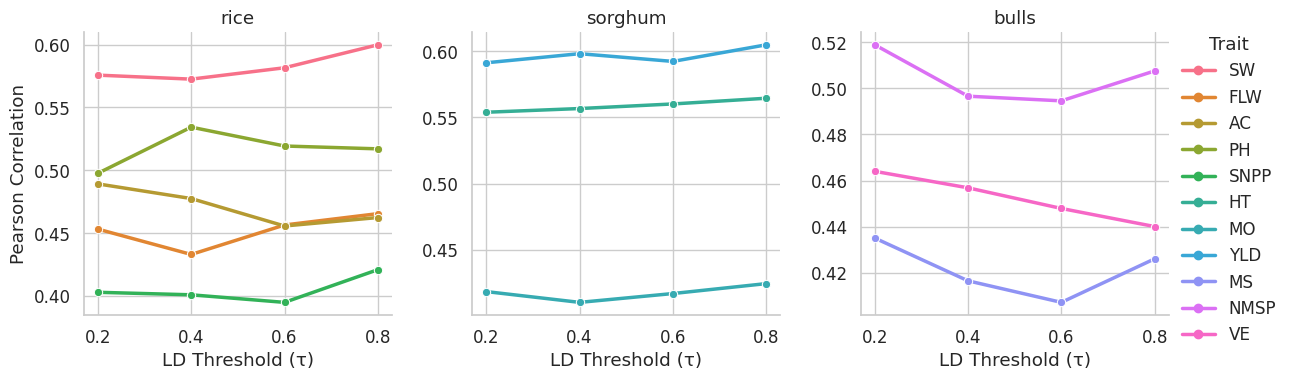

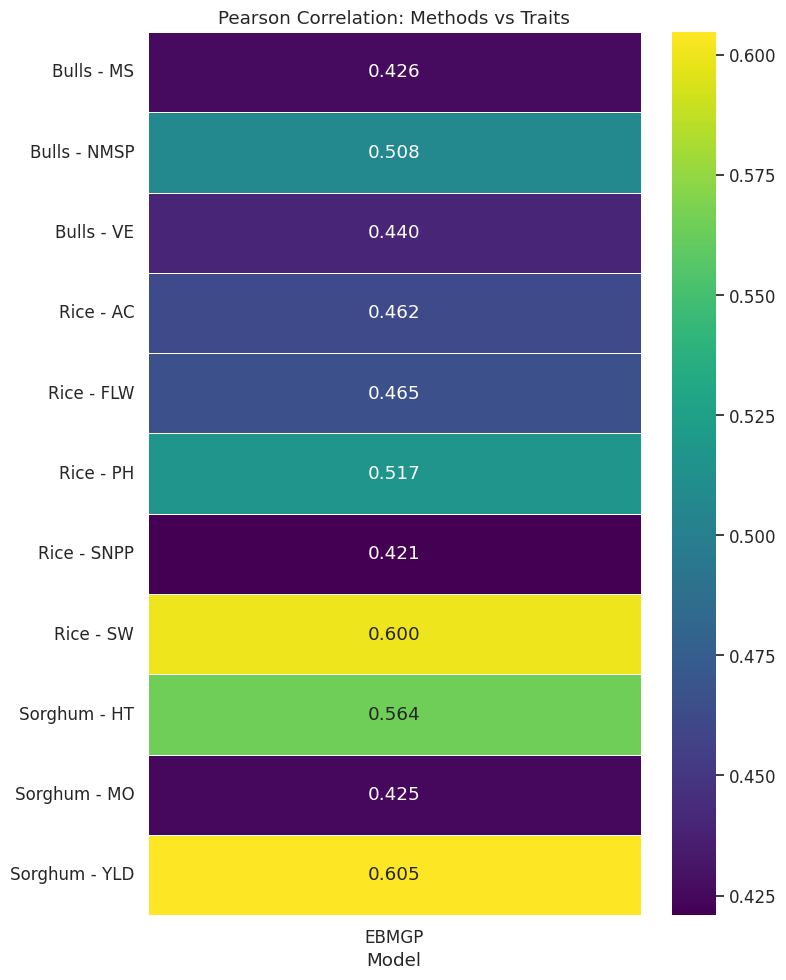

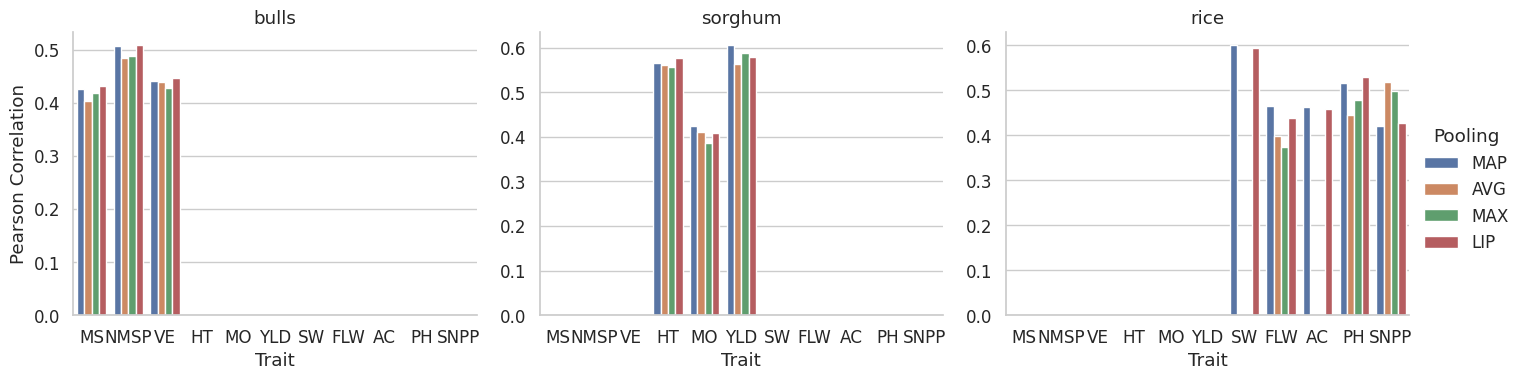

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os

# Set global style
sns.set_theme(style="whitegrid", font_scale=1.1)

def load_results_from_json(pattern):
    """Helper to load all JSONs matching a pattern into a DataFrame"""
    data = []
    files = glob.glob(pattern)
    for f in files:
        with open(f, 'r') as file:
            content = json.load(file)
            # Flatten the 'mean_corrs' dict into rows
            for trait, score in content.get('mean_corrs', {}).items():
                row = content.copy()
                del row['mean_corrs'] # remove dict
                if 'mean_RMSE' in row: del row['mean_RMSE']
                row['Trait'] = trait
                row['Pearson_Corr'] = score
                data.append(row)
    return pd.DataFrame(data)

# ---------------------------------------------------------
# 1. LD Ablation Curves (Line Plot)
# ---------------------------------------------------------
print("Generating LD Ablation Curves...")
df_ld = load_results_from_json("*_LD*.json")

if not df_ld.empty:
    # Filter for MAP pooling if mixed
    if 'pooling_type' in df_ld.columns:
        df_ld = df_ld[df_ld['pooling_type'] == 'MAP']
    
    g = sns.relplot(
        data=df_ld, 
        x="ld_threshold", y="Pearson_Corr", 
        hue="Trait", col="species", 
        kind="line", marker="o", linewidth=2.5,
        height=4, aspect=1, facet_kws={'sharey': False}
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("LD Threshold (τ)", "Pearson Correlation")
    plt.savefig("LD_Ablation_Curves.png", dpi=300, bbox_inches='tight')
    print("Saved: LD_Ablation_Curves.png")
else:
    print("No LD ablation JSON files found.")

# ---------------------------------------------------------
# 2. Benchmark Heatmap (Method x Trait)
# ---------------------------------------------------------
print("\nGenerating Benchmark Heatmap...")
# Load EBMGP results (assuming LD0.8 MAP is the standard EBMGP)
df_ebmgp = load_results_from_json("*_LD0.8.json")
if not df_ebmgp.empty:
    df_ebmgp['Model'] = 'EBMGP'
    df_ebmgp = df_ebmgp[['species', 'Trait', 'Model', 'Pearson_Corr']]

# Load Benchmark results
df_bench = load_results_from_json("*_GBLUP.json") 
df_bench = pd.concat([df_bench, load_results_from_json("*_BayesB.json")])
df_bench = pd.concat([df_bench, load_results_from_json("*_LightGBM.json")])

if not df_bench.empty and not df_ebmgp.empty:
    df_final = pd.concat([df_ebmgp, df_bench], ignore_index=True)
    
    # Create a pivot table for the heatmap
    # Pivot: Index=Trait(Species), Columns=Model, Values=Corr
    df_final['Label'] = df_final['species'].str.capitalize() + " - " + df_final['Trait']
    pivot_df = df_final.pivot_table(index='Label', columns='Model', values='Pearson_Corr')
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(pivot_df, annot=True, cmap="viridis", fmt=".3f", linewidths=.5)
    plt.title("Pearson Correlation: Methods vs Traits")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig("Benchmark_Heatmap.png", dpi=300)
    print("Saved: Benchmark_Heatmap.png")

# ---------------------------------------------------------
# 3. Pooling Comparison (Bar Chart)
# ---------------------------------------------------------
print("\nGenerating Pooling Comparison...")
# We look for files that look like species_T5000_TYPE.json where TYPE is MAP, AVG, etc.
# Note: Reuse logic from run_pooling_ablation naming convention
df_pool = pd.DataFrame()
for p_type in ["MAP", "AVG", "MAX", "LIP"]:
    temp = load_results_from_json(f"*_{p_type}.json")
    temp['Pooling'] = p_type
    df_pool = pd.concat([df_pool, temp])

if not df_pool.empty:
    g = sns.catplot(
        data=df_pool, 
        x="Trait", y="Pearson_Corr", hue="Pooling", col="species",
        kind="bar", height=4, aspect=1.2, sharey=False
    )
    g.set_axis_labels("Trait", "Pearson Correlation")
    g.set_titles("{col_name}")
    plt.savefig("Pooling_Comparison_Bar.png", dpi=300, bbox_inches='tight')
    print("Saved: Pooling_Comparison_Bar.png")

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# --- FIX SECTION START ---
# REDEFINED evaluate_epoch to handle batches with token_type_ids
def evaluate_epoch(model, loader, loss_fn, metric_fn, device):
    model.eval()
    running_loss = 0.0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in loader:
            # Move all tensors in the batch to the device
            batch = [t.to(device) for t in batch]
            
            # HANDLE BATCH UNPACKING
            if len(batch) == 3:
                # Case: [input_ids, token_type_ids, labels]
                b_input_ids, b_token_types, b_labels = batch
                outputs = model(b_input_ids, token_type_ids=b_token_types)
                target = b_labels
            elif len(batch) == 2:
                # Case: [input_ids, labels] - Attempt to generate dummy types or pass single
                b_input_ids, b_labels = batch
                target = b_labels
                try:
                    outputs = model(b_input_ids)
                except TypeError:
                    # If model strictly demands token_type_ids but loader didn't give them,
                    # generate zeros (common for single-sequence BERT models)
                    b_token_types = torch.zeros_like(b_input_ids, dtype=torch.long)
                    outputs = model(b_input_ids, token_type_ids=b_token_types)
            else:
                raise ValueError(f"Unexpected batch size: {len(batch)}")

            # Compute loss
            loss = loss_fn(outputs, target)
            running_loss += loss.item()
            
            # Store raw tensors
            all_preds.append(outputs)
            all_targets.append(target)

    # Concatenate lists into single Tensors immediately
    if len(all_preds) > 0:
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
    else:
        all_preds = torch.tensor([], device=device)
        all_targets = torch.tensor([], device=device)
    
    return running_loss / len(loader), all_preds, all_targets
# --- FIX SECTION END ---


# Configuration for the "Hero" plots
hero_plots = [
    {"species": "rice", "trait": "SW", "seed": 0},
    {"species": "sorghum", "trait": "YLD", "seed": 0},
    {"species": "bulls", "trait": "NMSP", "seed": 0}
]

for item in hero_plots:
    sp = item['species']
    tr = item['trait']
    sd = item['seed']
    
    print(f"Generating Diagnostics for {sp} - {tr}...")
    
    t_folder = "T5000" 
    data_path = f"./EN/{sp}/{t_folder}{tr}"
    
    config = species_config[sp]
    trait_idx = config['traits'].index(tr)
    
    if not os.path.exists(f"{data_path}{sd}.csv"):
        print(f"Skipping {sp}-{tr}: File {data_path}{sd}.csv not found.")
        continue

    # RUN TRAINING
    # This will now use the IMPROVED evaluate_epoch above
    corr, history, preds, targets = train_and_evaluate(
        trait_idx=trait_idx,
        species=sp,
        data_path=data_path,
        label_path=config["label_path"],
        geno_path=config["geno_path"],
        device=device,
        learning_rate=0.0005,
        epochs=100,
        seed=sd,
        sel_num=5000,
        ld_threshold=0.8,
        pooling_type="MAP"
    )
    
    # --- PLOTTING DATA PREP ---
    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
    elif isinstance(preds, list):
        preds = torch.cat(preds).detach().cpu().numpy()
        targets = torch.cat(targets).detach().cpu().numpy()
        
    preds = preds.flatten()
    targets = targets.flatten()
    # --------------------------
    
    # 1. Plot Loss Curve
    plt.figure(figsize=(6, 4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"Training Convergence: {sp.capitalize()} {tr}")
    plt.xlabel("Epoch")
    plt.ylabel("L1 Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    loss_filename = f"{sp}_{tr}_loss_curve.png"
    plt.savefig(loss_filename, dpi=300)
    plt.close()
    print(f"   Saved {loss_filename}")
    
    # 2. Plot Scatter (Pred vs Obs)
    plt.figure(figsize=(5, 5))
    
    d_min = min(np.min(preds), np.min(targets))
    d_max = max(np.max(preds), np.max(targets))
    pad = (d_max - d_min) * 0.1
    
    plt.scatter(targets, preds, alpha=0.6, edgecolors='w', s=50)
    plt.plot([d_min-pad, d_max+pad], [d_min-pad, d_max+pad], 'r--', label="Perfect Fit")
    
    plt.title(f"{sp.capitalize()} {tr} (r={corr:.3f})")
    plt.xlabel("Observed Phenotype (Standardized)")
    plt.ylabel("Predicted Phenotype")
    plt.xlim(d_min-pad, d_max+pad)
    plt.ylim(d_min-pad, d_max+pad)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    scat_filename = f"{sp}_{tr}_scatter.png"
    plt.savefig(scat_filename, dpi=300)
    plt.close()
    print(f"   Saved {scat_filename}")

Generating Diagnostics for rice - SW...
   Epoch 10/100 | Train Loss: 0.6724 | Val Loss: 0.6198 | Val Corr: 0.6238
   Epoch 20/100 | Train Loss: 0.5759 | Val Loss: 0.5259 | Val Corr: 0.6747
   Epoch 30/100 | Train Loss: 0.5152 | Val Loss: 0.5731 | Val Corr: 0.6571
   Epoch 40/100 | Train Loss: 0.4526 | Val Loss: 0.5335 | Val Corr: 0.6465
   Epoch 50/100 | Train Loss: 0.4180 | Val Loss: 0.5733 | Val Corr: 0.6150
   Epoch 60/100 | Train Loss: 0.4071 | Val Loss: 0.6127 | Val Corr: 0.6118
   Epoch 70/100 | Train Loss: 0.3965 | Val Loss: 0.5773 | Val Corr: 0.6114
   Epoch 80/100 | Train Loss: 0.3845 | Val Loss: 0.5386 | Val Corr: 0.6174
   Epoch 90/100 | Train Loss: 0.3982 | Val Loss: 0.5685 | Val Corr: 0.6264
   Epoch 100/100 | Train Loss: 0.3809 | Val Loss: 0.5285 | Val Corr: 0.6238
Finished. Final Test Correlation: 0.6238
   Saved rice_SW_loss_curve.png
   Saved rice_SW_scatter.png
Generating Diagnostics for sorghum - YLD...
   Epoch 10/100 | Train Loss: 0.5679 | Val Loss: 0.6775 | Val C

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

# Define the specific traits you listed in the LaTeX images section
target_plots = [
    ("rice", "AC"),
    ("rice", "FLW"),
    ("rice", "PH"),
    ("rice", "SNPP"),
    ("rice", "SW")
]

print("Generating Manhattan Plots...")

for species, trait in target_plots:
    # Construct pattern to find the file (e.g., ./EN/rice/T5000AC0.csv)
    # Using T5000 as default based on your text
    file_pattern = f"./EN/{species}/T5000{trait}0.csv" 
    
    files = glob.glob(file_pattern)
    if not files:
        print(f"  [Warning] No file found for {species} - {trait}")
        continue
        
    # Use the first seed (0) found
    filepath = files[0]
    
    try:
        df = pd.read_csv(filepath)
        
        plt.figure(figsize=(10, 4))
        # 'index' is the SNP location, 'cs' is the Elastic Net absolute coefficient
        plt.scatter(df['index'], df['cs'], c='navy', alpha=0.6, s=15, edgecolors='none')
        
        plt.title(f"Feature Importance (Elastic Net): {species.capitalize()} - {trait}")
        plt.xlabel("SNP Index")
        plt.ylabel("Selection Score (Abs Coeff)")
        
        # Add a baseline threshold line for visual context
        plt.axhline(y=0, color='grey', linewidth=0.5)
        
        plt.tight_layout()
        
        out_name = f"{species}_{trait}_manhattan.png"
        plt.savefig(out_name, dpi=300)
        plt.close()
        print(f"  Saved {out_name}")
        
    except Exception as e:
        print(f"  Error plotting {species}-{trait}: {e}")

Generating Manhattan Plots...
  Saved rice_AC_manhattan.png
  Saved rice_FLW_manhattan.png
  Saved rice_PH_manhattan.png
  Saved rice_SNPP_manhattan.png
  Saved rice_SW_manhattan.png


In [43]:
import math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = Path("figs")
OUTDIR.mkdir(exist_ok=True)

def plot_grid(name, df, cols, ncols=3, bins=30):
    k = len(cols)
    nrows = math.ceil(k / ncols)

    plt.figure(figsize=(4*ncols, 3.2*nrows))
    for i, col in enumerate(cols, 1):
        ax = plt.subplot(nrows, ncols, i)
        x = df[col].dropna()
        ax.hist(x, bins=bins)
        ax.set_title(col, fontsize=10)
        ax.set_xlabel(col, fontsize=9)
        ax.set_ylabel("count", fontsize=9)

    plt.suptitle(f"{name}: phenotype distributions (targets)", y=1.02, fontsize=14)
    plt.tight_layout()
    out = OUTDIR / f"{name}_phenotypes_grid.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.close()
    print("Saved:", out)

# Load
rice = pd.read_csv("./data/rice_pheno.csv", index_col=0)
sorghum = pd.read_csv("./data/sorghum_pheno.csv", index_col=0)
bulls = pd.read_csv("./data/bulls_pheno.csv", index_col=0)

# Choose target traits
rice_targets = [
    "Seed width",              # SW
    "Flag leaf width",         # FLW
    "Plant height",            # PH
    "Amylose content",         # AC
    "Seed number per panicle", # SNPP
]
sorghum_targets = ["MO", "YLD", "HT"]
bulls_targets = ["MS", "NMSP", "VE"]

plot_grid("rice", rice, rice_targets, ncols=3)
plot_grid("sorghum", sorghum, sorghum_targets, ncols=3)
plot_grid("bulls", bulls, bulls_targets, ncols=3)


Saved: figs/rice_phenotypes_grid.png
Saved: figs/sorghum_phenotypes_grid.png
Saved: figs/bulls_phenotypes_grid.png


In [45]:
import pandas as pd

datasets = {
    "rice": "./data/rice_pheno.csv",
    "sorghum": "./data/sorghum_pheno.csv",
    "bulls": "./data/bulls_pheno.csv",
}

for name, path in datasets.items():
    df = pd.read_csv(path, index_col=0, nrows=0) # nrows=0 reads only the header (very fast)
    print(f"--- {name.upper()} COLUMNS ---")
    print(df.columns.tolist())
    print("\n")

--- RICE COLUMNS ---
['Flowering time at Arkansas', 'Flowering time at Faridpur', 'Flowering time at Aberdeen', 'FT ratio of Arkansas/Aberdeen', 'FT ratio of Faridpur/Aberdeen', 'Culm habit', 'Leaf pubescence', 'Flag leaf length', 'Flag leaf width', 'Awn presence', 'Panicle number per plant', 'Plant height', 'Panicle length', 'Primary panicle branch number', 'Seed number per panicle', 'Florets per panicle', 'Panicle fertility', 'Seed length', 'Seed width', 'Seed volume', 'Seed surface area', 'Brown rice seed length', 'Brown rice seed width', 'Brown rice surface area', 'Brown rice volume', 'Seed length/width ratio', 'Brown rice length/width ratio', 'Straighthead suseptability ', 'Blast resistance', 'Amylose content', 'Alkali spreading value', 'Protein content', 'Year07Flowering time at Arkansas', 'Year06Flowering time at Arkansas', 'Sub-population']


--- SORGHUM COLUMNS ---
['MO', 'YLD', 'HT']


--- BULLS COLUMNS ---
['MS', 'NMSP', 'VE']


